In [1]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')

pd.options.mode.chained_assignment = None

from collections import Counter
import numpy as np
from word2number import w2n


# Set color palette to ORCA palette
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color=['#68829D', '#329B8A', '#D24437', '#F5B100', '#62ABB9', '#A3B100'])


# Get 100 random transcriptions

Tomaz has obtained 100 random transcriptions for each of the seven countries. Here, I collect all of these into a single dataframe

In [59]:
ls /efs-who/100-random-clips-transcriptions/100-random-clips/

ghana/  kenya/  mauritius/  namibia/  nigeria/  rwanda/  south_africa/  take-2/


In [60]:
ls /efs-who/100-random-clips-transcriptions/100-random-clips/take-2

kenya/


In [61]:
CLIPS_DIR = '/efs-who/100-random-clips-transcriptions/100-random-clips/'

In [62]:
transcriptions = []

for country in [c for c in os.listdir(CLIPS_DIR) if c!='take-2']:
    country_path = os.path.join(CLIPS_DIR, country)
    for city in os.listdir(country_path):
        city_path = os.path.join(country_path, city)
        for date in os.listdir(city_path):
            date_path = os.path.join(city_path, date)
            for csv in os.listdir(date_path):
                temp_df = pd.read_csv(os.path.join(date_path, csv))
                transcriptions.append({
                    "country": country,
                    "city": city,
                    "date": date,
                    "transcription": temp_df["date"].values[0],
                    "filename": temp_df["file name"].values[0]
                    
                })
#                 print(csv, date, city, country)        

In [63]:
deepspeech_df = pd.DataFrame(transcriptions)
# Drop null
deepspeech_df = deepspeech_df[~deepspeech_df.transcription.isnull()]
# Reset index
deepspeech_df.reset_index(inplace=True, drop=True)


In [64]:
len(deepspeech_df)

659

In [65]:
deepspeech_df.country.value_counts()

rwanda          100
nigeria         100
south_africa    100
namibia         100
ghana           100
mauritius        98
kenya            61
Name: country, dtype: int64

My process of obtaining these words:
* Starting with seed of "nineteen" and manually going through two transcriptions per country and seeing what variations of covid-19 were nearby"
* Using the EARS taxonomy and selectively choosing seed words related to symptoms, immunity, side effects, vaccines, and transmission. Randomly spot-check a few examples to make sure that the transcription for that seed word looks related to covid in some way

### Option 1: Using EARS to find covid segments

In [8]:
# ! wget https://raw.githubusercontent.com/UNGlobalPulse/UNGP-WHO-Radio-Dashboard/master/data/EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE

--2021-11-04 16:19:45--  https://raw.githubusercontent.com/UNGlobalPulse/UNGP-WHO-Radio-Dashboard/master/data/EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13501 (13K) [text/plain]
Saving to: ‘EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE.1’

EARSQueries_en.csv? 100%[===================>]  13.18K  --.-KB/s    in 0s      

2021-11-04 16:19:45 (97.5 MB/s) - ‘EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE.1’ saved [13501/13501]



In [182]:
def convert_boolean_to_regex(s):
    """Transforms a SQL-like boolean query to a regex... hope this works!"""
    # Replace OR and AND
    s = s.replace(" OR ", "|")
    # Replace quotations
    s = s.replace('"', '')
    # Drop the *
    s = s.replace('*', '')
    # replace NEAR/10
    s = s.replace(") NEAR/10 (", "|")
    # Special case with extra parens
    s = s.replace(")))) AND (", "|")
    s = s.replace("))) AND (", "|")
    s = s.replace("(", "")
    s = s.replace(")", "")

    # Lowercase
    s = s.lower()
    
    return s

def transcription_in_taxonomy(transcription):
    return any([w in transcription for w in covid_taxonomy])

In [183]:
covid_words = ["covert nineteen", "covered nineteen", "cove nineteen",
               "clover nineteen", "covet nineteen", "coffee nineteen",
               "crown of virus", "virus"]

ears_queries = pd.read_csv('EARSQueries_en.csv?token=ACHT7FCDL6RTPOVPMM4YS3TBRT2XE', header=None)
ears_queries.columns=['query_name', 'query']

In [184]:
ears_queries["regex_query"] = ears_queries["query"].apply(convert_boolean_to_regex)

# Append the taxonomy for radio covid words
ears_queries = ears_queries.append({
    "query_name": "COVID_WORDS",
    "regex_query": "|".join(covid_words)
}, ignore_index=True)

In [185]:
ears_queries

,query_name,query,regex_query
0,Cause,"""from animals"" OR ""deliberate spread"" OR ""labo...",from animals|deliberate spread|laboratory acci...
1,Stigma,stigma OR racism OR racist OR xenophobia OR xe...,stigma|racism|racist|xenophobia|xenophobic|int...
2,Immunity,"""immunity"" OR ""infected once"" OR ""develop immu...",immunity|infected once|develop immunity|grow i...
3,Confirmed Symptoms,"cough OR ""no breath"" OR ""breathless"" OR ""diffi...",cough|no breath|breathless|difficult to breath...
4,Other discussed symptoms,"""cold symptoms"" OR ""cold symptom"" OR ""Allergy ...",cold symptoms|cold symptom|allergy symptoms|al...
5,Asymptomatic,"""asymptom*""",asymptom
6,Pre-Symptomatic,"""pre-sympto*"" OR ""presympto*""",pre-sympto|presympto
7,Means of Transmission,"""transmi*"" OR ""spread"" OR ""transmitted"" OR ""dr...",transmi|spread|transmitted|droplets|propagate|...
8,Protection from Transmission,"""Personal Protective Equipment"" OR ""PPE"" OR ""g...",personal protective equipment|ppe|gloves|scrub...
9,Risk - Underlying Conditions,"""risk"" OR ""risk*"" OR ""danger"" OR ""threat"" OR ""...",risk|risk|danger|threat|threat|get|infect|wors...


In [32]:
ears_subset = ears_queries[ears_queries.query_name.isin(["Immunity", "Asymptomatic", "Means of Transmission",
                                          "Protection from Transmission", "Vaccines",
                                          "Reduction of Movement", "COVID_WORDS"])]

In [33]:
found_indices = set()

for i, q in ears_subset.iterrows():
    truth_values = deepspeech_df[deepspeech_df.transcription.apply(lambda x: bool(re.search(q["regex_query"], x)))]
    truth_value_indices = truth_values.index.values
    found_indices.update(truth_value_indices)
    print(len(found_indices))

2
2
229
300
308
316
320


In [34]:
covid_segmented_ears = deepspeech_df.iloc[list(found_indices)]

In [35]:
covid_segmented_ears.country.value_counts()

ghana           57
south_africa    56
nigeria         56
namibia         51
rwanda          39
mauritius       35
kenya           26
Name: country, dtype: int64

In [34]:
covid_segmented_ears[covid_segmented_ears.country=="ghana"]

NameError: name 'covid_segmented_ears' is not defined

### Option 2: Using curated covid taxonomy to find covid segments

In [90]:
covid_taxonomy = ["covert nineteen", "covered nineteen", "cove nineteen",  # covid 19
                  "clover nineteen", "covet nineteen", "coffee nineteen",  # covid 19
                  "coronated",
                  "symptom", "inoculating", "transmission", "transmit",
                  "vaccin", "variant", "virus", "doses", "delta", # vaccine
                  "oxford", "actinic vain", "johnson and",
                  "first wave", "second wave",
                  "immun", "infect", "contracted", # immunity
                  "quarantine", "pandemic", "preventative",
                  "side effect", # side effects
                 ]

def transcription_in_taxonomy(transcription):
    return any([w in transcription for w in covid_taxonomy])

In [91]:
covid_segmented_df = deepspeech_df[deepspeech_df.transcription.apply(transcription_in_taxonomy)]

In [92]:
covid_segmented_df.country.value_counts()

south_africa    13
namibia         12
rwanda           8
nigeria          5
kenya            5
ghana            3
mauritius        1
Name: country, dtype: int64

In [93]:
deepspeech_df.country.value_counts()

ghana           100
nigeria         100
namibia         100
south_africa    100
rwanda          100
mauritius        98
kenya            61
Name: country, dtype: int64

What percentage are "covid"-related? 

Mauritius is jibberish as is Ghana

(Caveat, Kenya only has 61 and idk why)

In [95]:
percentage_covid_segments = covid_segmented_df.country.value_counts() / deepspeech_df.country.value_counts()

In [97]:
percentage_covid_segments * 100

ghana            3.000000
kenya            8.196721
mauritius        1.020408
namibia         12.000000
nigeria          5.000000
rwanda           8.000000
south_africa    13.000000
Name: country, dtype: float64

## Copy and save relevant files to another folder

In [111]:
import os
import shutil
import glob

In [112]:
pip install pydub

  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
Note: you may need to restart the kernel to use updated packages.


In [113]:
from pydub import AudioSegment

In [ ]:
# convert wav to mp3                                                            


In [25]:
# Need to get 5 for each one
subset_countries = ['south_africa', 'namibia', 'rwanda', 'nigeria', 'kenya']
samples_to_segment = covid_segmented_df[covid_segmented_df.country.isin(subset_countries)]\
    .groupby("country")\
    .sample(n=5, random_state=42)

In [90]:
samples_to_segment.iloc[14].mp3_filename.split('/')

['',
 'efs-who',
 '100-random-clips',
 'nigeria',
 'ado-ekiti',
 '2021-10-08',
 'EktiRadio_2021-10-08T16.40.0.csv']

In [91]:
# Set the mp3 filename
samples_to_segment["mp3_filename"] = samples_to_segment.filename.str.replace('100-random-clips-transcriptions/100-random-clips', 
                                             '100-random-clips')

samples_to_segment["mp3_filename"] = samples_to_segment["mp3_filename"].str.replace('.csv', '')

<ipython-input-91-d3e3e65626c5>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  samples_to_segment["mp3_filename"] = samples_to_segment["mp3_filename"].str.replace('.csv', '')


In [122]:
'.'.join(filename.split('/')[-1].split('.')[:-1]) + '.wav'

'HBRRadio_2021-09-10T04.00.02.wav'

In [123]:
OUT_FOLDER = '/home/ubuntu/big_volume/covid_clips_before_segmenting'

for f in samples_to_segment["mp3_filename"]:
    filename = glob.glob(rf'{f}*')[0]
    
    out_file = os.path.join(OUT_FOLDER, '/'.join(filename.split('/')[3:6]))
    
    if not os.path.exists(out_file):
        os.makedirs(out_file)
        
    # Convert to WAV file
    audSeg = AudioSegment.from_mp3(filename)
    out_filename = os.path.join(out_file, '.'.join(filename.split('/')[-1].split('.')[:-1]) + '.wav')
    audSeg.export(out_filename, format="wav")
    
    # Before, we were just copying over the file
#     shutil.copy(filename, out_file)

In [125]:
samples_to_segment.iloc[14].mp3_filename

'/efs-who/100-random-clips/nigeria/ado-ekiti/2021-10-08/EktiRadio_2021-10-08T16.40.0'

In [51]:
# These are the ones (5 per country) we want to segment
samples_to_segment

,country,city,date,transcription,filename,mp3_filename
14,kenya,nairobi,2021-09-10,The door the cartoon lantejas of the departmen...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
47,kenya,kitale,2021-08-04,Lavish as to the niagaras ninety two per cent ...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/kitale/2021-08...
17,kenya,nairobi,2021-04-11,To a adoration to open a port ueberlassen say ...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
6,kenya,nairobi,2021-01-01,The right to a telemetering need to know if fi...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
20,kenya,nairobi,2021-09-05,The ups or is all as printing for your small b...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/kenya/nairobi/2021-0...
174,namibia,windhoek,2021-06-07,Official say to that men were deployed to secu...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
183,namibia,windhoek,2021-02-18,Not press for a long period of time i am what ...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
208,namibia,windhoek,2021-01-27,Let the lions now taking a look at was plain o...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
196,namibia,windhoek,2021-09-24,I was in the aneantissement is boltby renaissa...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...
254,namibia,windhoek,2021-09-25,What are we doing about it a sequence and a wi...,/efs-who/100-random-clips-transcriptions/100-r...,/efs-who/100-random-clips/namibia/windhoek/202...


In [35]:
ls /efs-who/100-random-clips/ghana

accra_central/  madina/


# Segmenting 5-Minute Audio Segments into Shorter Clips

## Intro
This notebook is a proof of concept for splitting the original 5-minute audio segment into shorter segments. These shorter clips will be used for 

1. Obtaining manual transcriptions from humans; and 
2. Validating several different ASR models

In an ideal world, we will have segments of 10-15 seconds. However, the segmenting is not perfect so we end up with longer segments (20 or 30 seconds) as well as really short ones (outlier of 2 seconds). However, we get a mean of 10 seconds, median of 8 seconds, so the chunking seems reasonable.

## Tools
* Using [`pydub`](https://github.com/jiaaro/pydub) to load in the WAV files and to export them
* Using [`Silero VAD`](https://github.com/snakers4/silero-vad#adaptive-way) to split the audio segments

## Files
* `.wav` audio files are kept in `INFILE`
* shorter segmented `.wav` files are outputted to `OUTFILE`. The format of the outputted files are: `<original_file_name>_<segment_number>.wav`
* `log_metadata.csv`: contains additional metadata with regards to each clip:
  * `original_file`: Name of the original audio file
  * `original_filepath`: Filepath of the original audio file
  * `chunk_num`: Which chunk number is it in the segmented file
  * `total_chunks`: How many chunks was the original file split into?
  * `chunk_duration_sec`: How many seconds long is this particular chunk?
  * `chunk_start_sec`: At what second timestamp of the original audio does this chunk begin?
  * `chunk_end_sec`: At what second timestamp of the original audio does this chunk end?
  * `country`: What country does this audio segment come from?
  * `station`: What station does this audio segment come from?

### Additional Information to include in metadata
When showing the audio files, we should show:
* The station
* The country -- this is important because peoples' names often come up and people might spell wrong
* Let's try and have a list of "important figures per country" or, if you find something from Zimbabwe then at least you know where to look for the name

### Dependencies

In [1]:
pip install pydub

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install -q torchaudio soundfile

Note: you may need to restart the kernel to use updated packages.


I had to do this on Linux... hope it's okay

`sudo apt install ffmpeg`

In [38]:
pip install -q torchaudio soundfile

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, re, glob, fnmatch, json
import pandas as pd
import numpy as np
import wave
import torch
torch.set_num_threads(1)
from pydub import AudioSegment
from collections import OrderedDict
from IPython.display import Audio
from pydub.utils import make_chunks

In [2]:
model, utils = torch.hub.load(repo_or_dir='snakers4/silero-vad',
                              model='silero_vad',
                              force_reload=True)

(get_speech_ts,
 get_speech_ts_adaptive,
 save_audio,
 read_audio,
 state_generator,
 single_audio_stream,
 collect_chunks) = utils

files_dir = torch.hub.get_dir() + '/snakers4_silero-vad_master/files'

Downloading: "https://github.com/snakers4/silero-vad/archive/master.zip" to /home/ubuntu/.cache/torch/hub/master.zip


### Code

In [68]:
INFILE = '/home/ubuntu/big_volume/covid_clips_before_segmenting'
OUTFILE = '/home/ubuntu/big_volume/covid_clips_after_segmenting'

# Get all of the original 5-minute segments (as a WAV)
audio_files = []

for country in os.listdir(INFILE):
    country_path = os.path.join(INFILE, country)
    for city in os.listdir(country_path):
        city_path = os.path.join(country_path, city)
        for date in os.listdir(city_path):
            date_path = os.path.join(city_path, date)
            for wav_file in os.listdir(date_path):
                filepath = os.path.join(date_path, wav_file)
                audio_files.append({
                    "filename": '.'.join(wav_file.split('.')[:-1]),
                    "filepath": filepath
                })

In [69]:
# Keep track of metadata in a log file
log_metadata = []

for row in audio_files:
  filename = row['filename']
  filepath = row['filepath']
  print("Processing:", filename)

  # Read in the audio file as a AudioSegment
  audio_file = AudioSegment.from_file(filepath, "wav") 
  # Read in the audio file as a tensor
  wav_tensor = read_audio(filepath)

  # Split the original audio into chunks using silero-vad
  speech_timestamps = get_speech_ts_adaptive(
    wav_tensor, 
    model, 
    step=500, 
    num_samples_per_window=4000, 
    min_speech_samples=80000, # 80000/16000 == 5 sec minimum per chunk
    min_silence_samples=2000, # Default 4000; lower value makes chunker more sensitive to shorter silences
  )

  print(f"Splitting into {len(speech_timestamps)} chunks")

  # Iterate through timestamp chunks and split original wav file by those times  
  for i, ts in enumerate(speech_timestamps):
    duration_in_sec = round((ts['end'] - ts['start'])/16000)
    chunk = audio_file[ts['start']/16:ts['end']/16]
    
    country = filepath.split('/')[5]
    city = filepath.split('/')[6]
    
    chunk_filename = f'{country}_{city}_{filename}'
    chunk.export(os.path.join(OUTFILE, f'{chunk_filename}_{i}.wav'), format="wav")

    log_metadata.append({
        "chunk_filename": chunk_filename,
        "original_file": filename,
        "original_filepath": filepath,
        "country": country,
        "city": city,
        "date": filepath.split('/')[7],
        "station": filepath.split('/')[8].split('_')[0],
        "chunk_num": i,
        "total_chunks": len(speech_timestamps),
        "chunk_duration_sec": duration_in_sec,
        "chunk_start_sec": ts['start']/16000,
        "chunk_end_sec": ts['end']/16000,
    })

Processing: HBRRadio_2021-01-01T06.00.01
Splitting into 3 chunks
Processing: HBRRadio_2021-09-10T04.00.02
Splitting into 9 chunks
Processing: HBRRadio_2021-04-11T16.20.02
Splitting into 10 chunks
Processing: MeruFM_2021-09-05T15.40.01
Splitting into 13 chunks
Processing: RadioSafariFM_2021-08-04T03.45.01
Splitting into 16 chunks
Processing: CapeTalk_2021-02-12T14.00.01
Splitting into 17 chunks
Processing: HeartFM_2021-09-20T15.00.01
Splitting into 17 chunks
Processing: CapeTalk_2021-09-11T05.50.01
Splitting into 15 chunks
Processing: VumaFM_2021-02-03T04.00.01
Splitting into 11 chunks
Processing: EastCoastRadio_2021-08-11T10.00.01
Splitting into 10 chunks
Processing: EagleFM_2021-06-07T03.45.01
Splitting into 17 chunks
Processing: EagleFM_2021-02-18T00.15.01
Splitting into 7 chunks
Processing: OmulungaRadio_2021-09-24T11.30.01
Splitting into 7 chunks
Processing: EagleFM_2021-01-27T03.40.02
Splitting into 21 chunks
Processing: EagleFM_2021-09-25T02.30.02
Splitting into 10 chunks
Process

In [70]:
log_metadata_df = pd.DataFrame(log_metadata)

In [71]:
chunk

In [72]:
log_metadata_df.rename(columns={"chunk_duration_se": "chunk_duration_sec"}, inplace=True)

<AxesSubplot:>

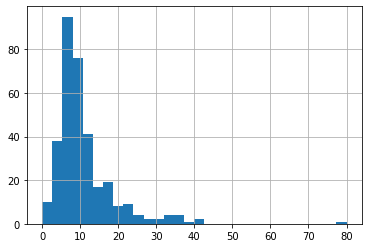

In [80]:
log_metadata_df.chunk_duration_sec.hist(bins=30)

In [74]:
log_metadata_df.chunk_duration_sec.describe()

count    333.000000
mean      10.729730
std        7.970895
min        0.000000
25%        6.000000
50%        8.000000
75%       13.000000
max       80.000000
Name: chunk_duration_sec, dtype: float64

In [81]:
np.median(log_metadata_df.chunk_duration_sec)

8.0

Note: So I just did 3 5-minutes segments and got about 60 segments.
That is about 20 segments per clip, which is great!

In [76]:
log_metadata_df.to_csv(os.path.join(OUTFILE, 'log_metadata.csv'))

In [84]:
chunk_filenameme

'nigeria_ado-ekiti_EktiRadio_2021-10-08T16.40.01'

# Analysis on Segmented Covid-related clips

We collected 5 random snippets from 5 countries, each 5-min long. So, 5*5*5 == 125 minutes

In [66]:
DIR_NAME = '/home/ubuntu/big_volume/covid_clips_after_segmenting'
log_metadata = pd.read_csv(f'{DIR_NAME}/log_metadata.csv')

In [67]:
log_metadata.chunk_duration_sec.describe()

count    333.000000
mean      10.729730
std        7.970895
min        0.000000
25%        6.000000
50%        8.000000
75%       13.000000
max       80.000000
Name: chunk_duration_sec, dtype: float64

In [68]:
# How many segments per country?
log_metadata.country.value_counts()

nigeria         77
rwanda          73
south_africa    70
namibia         62
kenya           51
Name: country, dtype: int64

In [69]:
# Average chunk time length per country
log_metadata.groupby('country')['chunk_duration_sec'].mean()

country
kenya           12.000000
namibia         12.483871
nigeria          9.376623
rwanda           8.712329
south_africa    11.842857
Name: chunk_duration_sec, dtype: float64

In [70]:
log_metadata[['chunk_duration_sec', 'country']]

,chunk_duration_sec,country
0,16,kenya
1,80,kenya
2,5,kenya
3,11,kenya
4,35,kenya
...,...,...
328,37,nigeria
329,22,nigeria
330,22,nigeria
331,6,nigeria


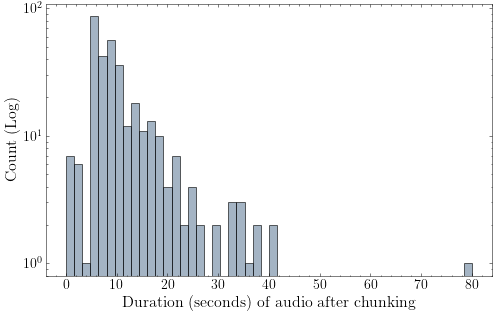

In [304]:
plt.figure(figsize=(8,5))
plt.hist(log_metadata['chunk_duration_sec'], 50, alpha=0.6, edgecolor='black')
plt.xticks(size=14)
plt.xlabel('Duration (seconds) of audio after chunking', size=16)
plt.yticks(size=14)
plt.yscale('log')
plt.ylabel('Count (Log)', size=16)
# plt.show()
plt.savefig('img/APPENDIX_audio_duration_after_chunking.pdf', bbox_inches='tight') 


In [305]:
data = []
for country in log_metadata.country.unique():
    data.append(log_metadata[log_metadata.country==country].chunk_duration_sec.values)
    

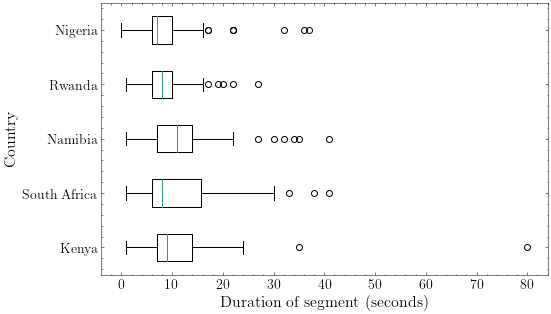

In [306]:
plt.figure(figsize=(8,5))

plt.boxplot(data, vert=False)
plt.yticks(range(1,6), ['Kenya', 'South Africa', 'Namibia', 'Rwanda', 'Nigeria'], size=14)
plt.ylabel('Country', size=16)
plt.xticks(size=14)
plt.xlabel('Duration of segment (seconds)', size=16)


# plt.show()
plt.savefig('img/APPENDIX_duration_of_audio_segment_boxplot.pdf', bbox_inches='tight') 


## Pitch Analysis

In [182]:
# https://pypi.org/project/crepe/
# pip install --upgrade tensorflow
# pip install crepe
import crepe
from scipy.io import wavfile

Crepe: https://github.com/marl/crepe

CREPE: A Convolutional Representation for Pitch Estimation from the paper: https://arxiv.org/abs/1802.06182

In [123]:
DIR_NAME = '/home/ubuntu/big_volume/covid_clips_after_segmenting'
covid_segments = os.listdir(DIR_NAME)

In [ ]:
# Testing on just one

In [183]:
sr, audio = wavfile.read(f'{DIR_NAME}/{covid_segments[0]}')
time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)

21/21 [==============================] - 10s 458ms/step


In [190]:
# Time is by 0.01 second splits
time[0:10]

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])

In [192]:
# Can also do confidence scores
confidence[0:10]

array([0.12383583, 0.1569506 , 0.11245608, 0.40124017, 0.6058458 ,
       0.7163856 , 0.852736  , 0.9140115 , 0.898927  , 0.90589654],
      dtype=float32)

In [ ]:
frequency_list = []


In [196]:
len(frequency_list)

66

In [197]:
for c in covid_segments[67:]:
    sr, audio = wavfile.read(f'{DIR_NAME}/{c}')
    time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)
    frequency_list.append({
        "filename": c,
        "frequencies": frequency
    })


13/13 [==============================] - 6s 457ms/step


/home/ubuntu/anaconda3/envs/yennie/lib/python3.9/site-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]


29/29 [==============================] - 13s 457ms/step


/home/ubuntu/anaconda3/envs/yennie/lib/python3.9/site-packages/crepe/core.py:209: RuntimeWarning: invalid value encountered in true_divide
  frames /= np.std(frames, axis=1)[:, np.newaxis]


22/22 [==============================] - 10s 459ms/step


In [ ]:
frequency_list_df = pd.DataFrame(frequency_list)
frequency_list_df["num_frequencies"] = frequency_list_df.frequencies.apply(len)
frequency_list_df["mean_frequencies"] = frequency_list_df.frequencies.apply(np.mean)
frequency_list_df["min_frequency"] = frequency_list_df.frequencies.apply(min)
frequency_list_df["max_frequency"] = frequency_list_df.frequencies.apply(max)

In [82]:
FILENAME = '/home/ubuntu/big_volume/covid_clips_after_segmenting/covid_segments_frequency_list.csv'

In [ ]:
frequency_list_df.to_csv(FILENAME, index=False)

In [81]:
frequency_list_df = pd.read_csv(FILENAME)

An adult woman's average range is from 165 to 255 Hz, while a man's is 85 to 155 Hz. https://leader.pubs.asha.org/doi/10.1044/leader.FTR1.24022019.44#:~:text=In%20general%2C%20women%20speak%20at,cords%20to%20elongate%20and%20thicken.

In [83]:
all_frequencies = [a for sublist in frequency_list_df.frequencies for a in sublist]

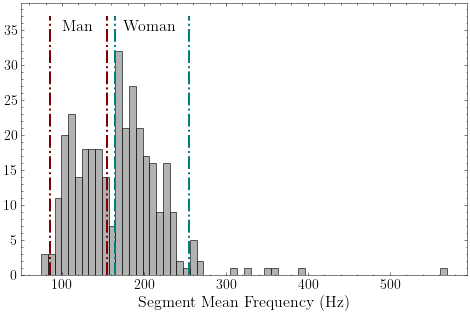

In [308]:
plt.figure(figsize=(8,5))

plt.hist(frequency_list_df.mean_frequencies, color='gray', bins=60, alpha=0.6, edgecolor='black')
plt.xlabel('Segment Mean Frequency (Hz)', size=16)
plt.xticks(size=14)
plt.yticks(size=14)

plt.vlines(x=[165, 255], ymin=[0, 0], ymax=[37,37], colors='teal', ls='-.', lw=2, label='vline_multiple - partial height')
plt.text(100, 35, 'Man', size=16)

plt.vlines(x=[85, 155], ymin=[0, 0], ymax=[37,37], colors='maroon', ls='-.', lw=2, label='vline_multiple - partial height')
plt.text(175, 35, 'Woman', size=16)


# plt.show()
plt.savefig('img/APPENDIX_pitch_frequency_gender.pdf', bbox_inches='tight') 


# Transcriptions!

## Original Audio Files

In [2]:
DIR_NAME = '/home/ubuntu/big_volume/covid_clips_after_segmenting'
covid_segments = os.listdir(DIR_NAME)

In [3]:
len(covid_segments)

335

## Human Transcriptions

In [4]:
human_segments = pd.read_csv('label_studio_transcriptions_12_09_2021_v2.csv')

# Obtain just the WAV filename path with regex
human_segments["wav_filename"] = human_segments.audio.apply(lambda x: '-'.join(x.split('-')[1:]))

# Shuffle the order
human_segments = human_segments.sample(frac=1, random_state=42)

In [5]:
human_segments.wav_filename.nunique()

333

In [6]:
human_segments.audio_language.value_counts()

English                                    410
Non-English                                206
{"choices": ["English", "Non-English"]}      7
Name: audio_language, dtype: int64

In [7]:
# Ensure that each round of transcriptions gets its own row
dups = human_segments[["wav_filename", "transcription", "annotator", "gender", "audio_language", "audio_quality", "additional_notes", "annotation_id"]]

# The first transcription for same wavfile
d1 = dups[dups.wav_filename.duplicated()]

# The second transcription for same wavfile
d2 = dups.drop_duplicates('wav_filename')

len(dups), len(d1), len(d2)

(667, 334, 333)

In [8]:
# Merge the first and last transcription duplicates
human_seg_df = d2.merge(d1, how='left', on='wav_filename', suffixes=["_1", "_2"])

# # Sort the columns so they're in order
# human_seg_df = human_seg_df[['wav_filename'] \
#                             + sorted(human_seg_df.columns)[:-1][-2:] \
#                             + sorted(human_seg_df.columns)[:-1][4:-2]]


# Rename transcription column
human_seg_df = human_seg_df.rename(columns={"transcription_1": "transcription_human1", 
                             "transcription_2": "transcription_human2"})

### Cohen Kappa agreement

In [25]:
# Can do additional stuff on annotator agreement for gender, transcription, audio quality, etc...
# Calculating only on those that are not null for BOTH transcriptors

In [26]:
from sklearn.metrics import cohen_kappa_score

In [27]:
humans_gender_not_null = human_seg_df[(human_seg_df.gender_2.notnull()) & (human_seg_df.gender_1.notnull())]
cohen_kappa_score(humans_gender_not_null["gender_1"], humans_gender_not_null["gender_2"])

0.8651448639157155

In [28]:
humans_quality_not_null = human_seg_df[(human_seg_df.audio_quality_1.notnull()) & (human_seg_df.audio_quality_2.notnull())]
cohen_kappa_score(humans_quality_not_null["audio_quality_1"], humans_quality_not_null["audio_quality_2"])


0.16802892764322575

In [29]:
humans_lang_not_null = human_seg_df[(human_seg_df.audio_language_1.notnull()) & (human_seg_df.audio_language_2.notnull())]
cohen_kappa_score(humans_lang_not_null["audio_language_1"], humans_lang_not_null["audio_language_2"])


0.8749937258445013

## AWS Transcriptions

In [9]:
DIR_NAME = '/efs-who/big_volume/covid_clips_after_segmenting-transcripts-aws'
aws_segments_filenames = os.listdir(DIR_NAME)
len(aws_segments_filenames)

664

In [10]:
aws_segments = []
for fn in aws_segments_filenames:
    # Only get txt files
    if '.txt' in fn:
        with open(f'{DIR_NAME}/{fn}') as f:
            lines = f.read()
        aws_segments.append({
            "filename": f'{DIR_NAME}/{fn}',
            "wav_filename": fn.split('.transcription.')[0],
            "transcription_aws": lines
        })
        

In [11]:
aws_seg_df = pd.DataFrame(aws_segments)
aws_seg_df.head()

,filename,wav_filename,transcription_aws
0,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_cape_town_CapeTalk_2021-02-12T14....,"Good afternoon, I'm Wesley Peterson, 12 people..."
1,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_lagos_LagosTalks_2021-10-12T10.35.01_1...,"It's important in nerve functioning, blood clo..."
2,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_EastCoastRadio_2021-08-11T...,In the caucus of the a n c then meets and then...
3,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_lagos_NigeriaInfoLagos_2021-02-01T11.5...,"So that seems to be financially free, you send..."
4,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_EagleFM_2021-02-18T00.15.01_0...,"Okay, dr um what are the other dangers that a ..."


## DeepSpeech Transcriptions

In [12]:
DIR_NAME = '/efs-who/big_volume/covid_clips_after_segmenting-transcripts-deepspeech'
deepspeech_segments_filenames = os.listdir(DIR_NAME)

deepspeech_segments_filenames = [d for d in deepspeech_segments_filenames if d not in 
                                 ['log_metadata.csv', 'covid_segments_frequency_list.csv',
                                  'log_metadat.csv', 'covid_segments_frequency_lis.csv']]

len(deepspeech_segments_filenames)

358

In [13]:
import csv

In [14]:
ds_segments = []
for fn in deepspeech_segments_filenames:
    with open(f'{DIR_NAME}/{fn}') as csvfile:
        data = csv.reader(csvfile)
        row = list(data)[1]
        
        ds_segments.append({
            "filename": f'{DIR_NAME}/{fn}',
            "wav_filename": re.sub('.csv', '.wav', row[3].split('/')[-1]),
            "transcription_deepspeech": row[2]
        })


In [15]:
ds_seg_df = pd.DataFrame(ds_segments)
ds_seg_df.head()

,filename,wav_filename,transcription_deepspeech
0,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_EastCoastRadio_2021-08-11T...,He would have the potential to be very lengthy...
1,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_OmulungaRadio_2021-09-24T11.3...,On the other side of the spectrum a dutch cour...
2,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_lagos_NigeriaInfoLagos_2021-02-01T11.5...,Spent unenclosed representation by a chicago o...
3,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_VumaFM_2021-02-03T04.00.01...,To follow the few
4,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_cape_town_CapeTalk_2021-02-12T14....,On east to a five and a position five six seven


## NVIDIA (riva) Transcriptions

In [16]:
DIR_NAME = '/efs-who/big_volume/covid_clips_after_segmenting-transcripts-riva'
riva_segments_filenames = os.listdir(DIR_NAME)
len(riva_segments_filenames)

666

In [17]:
riva_segments = []
for fn in riva_segments_filenames:
    # Only get txt files
    if '.txt' in fn:
        with open(f'{DIR_NAME}/{fn}') as f:
            lines = f.read()
        riva_segments.append({
            "filename": f'{DIR_NAME}/{fn}',
            "wav_filename": fn.split('.transcription.')[0],
            "transcription_riva": lines
        })
        

In [18]:
riva_seg_df = pd.DataFrame(riva_segments)
riva_seg_df.head()

,filename,wav_filename,transcription_riva
0,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_abeokuta_OgunRadioFM_2021-09-03T11.05....,su hundred 31 new cases of virus were recorded...
1,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_EagleFM_2021-02-18T00.15.01_0...,okay dr. um what are the other dangers that a ...
2,/efs-who/big_volume/covid_clips_after_segmenti...,nigeria_ado-ekiti_EktiRadio_2021-10-08T16.40.0...,a cooler outbreak has killed about 20 resident...
3,/efs-who/big_volume/covid_clips_after_segmenti...,namibia_windhoek_EagleFM_2021-06-07T03.45.01_8...,there's aging as far as i.e. concerned we take...
4,/efs-who/big_volume/covid_clips_after_segmenti...,south_africa_durban_EastCoastRadio_2021-08-11T...,then the caucus of the ac then meets and then ...


## Merge

In [19]:
# pip install word2number


In [20]:
word2num = {
    "zero": 0,
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6, 
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10,
    "eleven": 11,
    "twelve": 12,
    "thirteen": 13,
    "fourteen": 14,
    "fifteen": 15,
    "sixteen": 16,
    "seventeen": 17,
    "eighteen": 18,
    "nineteen": 19,
    "twenty": 20,
    "thirty": 30,
    "forty": 40,
    "fifty": 50,
    "sixty": 60,
    "seventy": 70,
    "eighty": 80,
    "ninety": 90,
    "hundred": 100,
    "thousand": 1000,
}

In [21]:
# Merge all of the DFs together
merged_df = riva_seg_df[["wav_filename", "transcription_riva"]]\
    .merge(ds_seg_df[["wav_filename", "transcription_deepspeech"]], on=["wav_filename"])\
    .merge(aws_seg_df[["wav_filename", "transcription_aws"]], on=["wav_filename"])\
    .merge(human_seg_df, on='wav_filename')

# Additional metadata from filename
merged_df["country"] = merged_df.wav_filename.apply(lambda x: x.split("_")[0].title())
merged_df["city"] = merged_df.wav_filename.apply(lambda x: x.split("_")[-4].title())
merged_df["station"] = merged_df.wav_filename.apply(lambda x: x.split("_")[-3])
merged_df["datetime"] = merged_df.wav_filename.apply(lambda x: x.split("_")[-2])

# Fix a few errors from underscore (south africa being south_africa)
merged_df.loc[merged_df.country=="South", "country"] = "South Africa"
merged_df.loc[((merged_df.city=="Town") & (merged_df.country=="South Africa")), "city"] = "Cape Town"

len(merged_df)

333

In [22]:
# Lots of non-english clips for Rwanda (at least so far)
# If at least one annotator has said it was non-english
non_english = merged_df[(merged_df.audio_language_1 == "Non-English") | (merged_df.audio_language_1 == "Non-English")]
non_english.country.value_counts()



Rwanda          68
Kenya           28
Nigeria          1
South Africa     1
Name: country, dtype: int64

In [23]:
merged_df.audio_language_1.value_counts()

English                                    202
Non-English                                 98
{"choices": ["English", "Non-English"]}      5
Name: audio_language_1, dtype: int64

In [24]:
merged_df.audio_language_2.value_counts()

English                                    208
Non-English                                107
{"choices": ["English", "Non-English"]}      2
Name: audio_language_2, dtype: int64

In [25]:
# Only look at clips in English
english_clips = merged_df[(merged_df.audio_language_1 != "Non-English") & (merged_df.audio_language_2 != "Non-English")]

# Fill null transcriptions with empty str for now
english_clips.transcription_human1 = english_clips.transcription_human1.fillna("")
english_clips.transcription_human2 = english_clips.transcription_human2.fillna("")

english_clips.country.value_counts()

Nigeria         73
South Africa    67
Namibia         61
Kenya           20
Name: country, dtype: int64

In [26]:
# Lowercase 
for t in ["transcription_riva", "transcription_deepspeech", "transcription_aws",
          "transcription_human1", "transcription_human2"]:
    # Lowercase
    s = english_clips[t].apply(str.lower)
    
    # Replace dr. with doctor
    s = s.apply(lambda x: re.sub(r'\bdr\.', 'doctor', x))
    
    # Replace um+ with um
    s = s.apply(lambda x: re.sub(r'\bum+', 'um', x))
    
    # Replace eh, uh+ with uh
    s = s.apply(lambda x: re.sub(r'\beh\b', 'uh', x))
    s = s.apply(lambda x: re.sub(r'\buh+', 'uh', x))
    s = s.apply(lambda x: re.sub(r'\bah+', 'uh', x))
    
    # Replace alright with all right
    s = s.apply(lambda x: re.sub(r'\balright', 'all right', x))
    
    # Replace covid
    s = s.apply(lambda x: re.sub(r'\bcovid19', 'covid 19', x))
    
    s = s.apply(lambda x: re.sub(r'\b6:00', "six o'clock", x))
    s = s.apply(lambda x: re.sub(r'\bfive thousand', "5000", x))
    
    # Replace number words with their proper value
    for i in word2num.keys():
        s = s.apply(lambda x: re.sub(fr'\b{i}\b', str(word2num[i]), x))
       
    # Remove the following punctuation: .,-?
    s = s.str.replace('\.|,|\?|-', '')
    
    # Remove newlines
    s = s.str.replace('\n', '')
    
    english_clips[t] = s

<ipython-input-26-4909aef8bb6d>:32: FutureWarning: The default value of regex will change from True to False in a future version.
  s = s.str.replace('\.|,|\?|-', '')


In [27]:
riva_counter = Counter([a for sublist in english_clips.transcription_riva.values for a in sublist.split(" ")])
ds_counter = Counter([a for sublist in english_clips.transcription_deepspeech.values for a in sublist.split(" ")])
aws_counter = Counter([a for sublist in english_clips.transcription_aws.values for a in sublist.split(" ")])

human1_counter = Counter([a for sublist in english_clips.transcription_human1.values for a in sublist.split(" ")])

human2_counter = Counter([a for sublist in english_clips.transcription_human2.values for a in sublist.split(" ")])

In [28]:
merged_df.to_csv('merged_df.csv', index=False)
english_clips.to_csv('english_clips.csv', index=False)

In [29]:
# english_clips = pd.read_csv('english_clips.csv')

In [30]:
english_clips[["transcription_riva", "transcription_deepspeech", "transcription_aws",
           "transcription_human1", "transcription_human2"]].loc[159].values

array(['kara state government has warned health officials against issuing covid 9 vaccination cards to people who refuse to be vaccinated but wish to acquire the cards the executive secretary of the quar state primary health care development agency dr noser au gave the warning at a news conference in i lori to condemn the alleged acquisition of such vaccination cards by those who will not want to be vaccinated',
       "while as did comment as 1 held officials against it in covington location chart to people who refuse to be buttoned but which to a cloud the carts the editor secretary of the protested primary health care development agency doctor nora all give the 1 in at news conference in the lorry to condemn the let a position of subornation clouds by those who don't want to be lacinated",
       'kwara state government as 1 health officials against covid 19 vaccination cards to people who refuse to be vaccinated but wish to acquire the cards the executive secretary of the kwara sta

In [31]:
english_clips[["transcription_riva", "transcription_deepspeech", "transcription_aws",
           "transcription_human1", "transcription_human2"]]

,transcription_riva,transcription_deepspeech,transcription_aws,transcription_human1,transcription_human2
0,su 100 31 new cases of virus were recorded in ...,sometimes a new kisses of the various when he ...,1631 new cases of the virus were recorded in 1...,<unknown> <unknown> 1 new case of the virus wa...,<unknown> that 1 new case of the virus were re...
1,okay doctor um what are the other dangers that...,1 note and what are the other dangers that a d...,okay dr um what are the other dangers that a u...,um okay doctor what are the other dangers that...,okay doctor um what are the other dangers that...
2,a cooler outbreak has killed about 20 resident...,a caller outbreak as killed about 20 residents...,a cholera outbreak has killed about 20 residen...,a cholera outbreak has killed about 20 residen...,a color outbreak is killed about 20 residents ...
3,there's aging as far as ie concerned we take a...,and that is a getting his fire that is concern...,and that is what we're getting as far as that ...,<trunc> that is concerned we'll take a look at...,<unknown> 5 that is concerned uh we take a loo...
4,then the caucus of the ac then meets and then ...,in the process of the ice the needs and then d...,in the caucus of the a n c then meets and then...,then the caucus of the anc then meets and then...,then the caucus of the anc then meets and deci...
...,...,...,...,...,...
326,what crime in justice a brand new kenyon show ...,what crime and justice a bran new kennon shamu...,watch crime and justice a brand new kenyan sho...,watch crime & justice a brand new kenyan show...,what <unknown> justice a brand new <unknown> c...
327,miners died after sneaking into the old pit of...,my sight after sinking into the old pet of a g...,legal miners died after sneaking into the old ...,<unknown> died after sneaking into the old <un...,several miners died after sneaking into the ol...
329,let's get it this friday morning at 2 min past...,let's give this friday morning it to man's pos...,let's get it this friday morning at 2 minutes ...,let's give it this friday morning at 2 minutes...,lets get it this friday morning at 2 minutes p...
330,however of course you know that it's that detr...,however cause you know that its sad detriment ...,however of course you know that it's detriment...,however of course you know that it is such det...,however off cause you know that it is detrimen...


## Metrics

In [32]:
# https://pypi.org/project/jiwer/
# pip install jiwer

In [33]:
from jiwer import wer, mer, wil

def calc_wer(row, t1, t2):
    if len(row[t1]) and len(row[t2]) > 0:
        return wer(row[t1], row[t2])
    
def calc_mer(row, t1, t2):
    if len(row[t1]) and len(row[t2]) > 0:
        return mer(row[t1], row[t2])
    
def calc_wil(row, t1, t2):
    if len(row[t1]) and len(row[t2]) > 0:
        return wil(row[t1], row[t2])

### Let's get the WER between annotators

**TO DO** for the inter annotator agreement cross-checking
* Before submitting transcriptions as ground truth, let's first compare the two annotator transcriptions
* Plot a histogram of agreement scores
* Select the ones that pass a threshold of agreement scores

Once this then I can do what I am doing afterwards of comparing the AWS/RIVA/DS for each of the transcriptions

In [34]:
english_clips["inter_annotator_wer"] = english_clips.apply(calc_wer, args=("transcription_human1", "transcription_human2"), axis=1)

# Calculate the 90th quantile
english_clips["inter_annotator_wer"].quantile(0.9)

0.5714285714285714

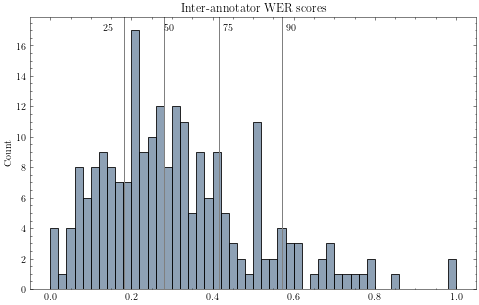

In [35]:
plt.figure(figsize=(8,5))

wer_describe = english_clips["inter_annotator_wer"].describe()

sns.histplot(english_clips["inter_annotator_wer"].values, bins=50)
plt.axvline(wer_describe["25%"], color='gray')
plt.text(wer_describe["25%"]-0.05, 17, '25%')
plt.axvline(wer_describe["50%"], color='gray')
plt.text(wer_describe["50%"], 17, '50%')
plt.axvline(wer_describe["75%"], color='gray')
plt.text(wer_describe["75%"]+0.01, 17, '75%')

plt.axvline(english_clips["inter_annotator_wer"].quantile(0.9), color='gray')
plt.text(english_clips["inter_annotator_wer"].quantile(0.9)+0.01, 17, '90%')

plt.title('Inter-annotator WER scores')
plt.show()

In [36]:
ninety_quantile = english_clips["inter_annotator_wer"].quantile(0.9)
ninety_quantile, len(english_clips), len(english_clips[english_clips["inter_annotator_wer"] > ninety_quantile])



(0.5714285714285714, 221, 21)

In [37]:
len(english_clips[english_clips["inter_annotator_wer"] > ninety_quantile]), \
len(english_clips[english_clips["inter_annotator_wer"] <= ninety_quantile])


(21, 200)

In [38]:
# Only keep clips were inter-annotator WER is within the 90th quantile
# Discard rows with inter-annotator agreement higher than certain threshold
english_clips = english_clips[english_clips["inter_annotator_wer"] <= ninety_quantile]
print(len(english_clips))

200


**TODO**: Need to discard the rows of human transcriptions that have inter-annotator agreement higher than a certain threshold

In [39]:
english_clips.country.value_counts()

Nigeria         63
South Africa    63
Namibia         57
Kenya           17
Name: country, dtype: int64

### Let's get WER, MER, WIL

In this case, we are comparing everything against `human1` as the ground truth. 

#### WER - lower is better, 1 is bad

In [40]:
# for func_name, func in zip(["wer", "mer", "wil"], [calc_wer, calc_mer, calc_wil]):
#     for i, ground_truth in enumerate(["transcription_human1", "transcription_human2"]):
#         english_clips[f"riva_{i+1}_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_riva"), axis=1)
#         english_clips[f"ds_{i+1}_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_deepspeech"), axis=1)
#         english_clips[f"aws_{i+1}_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_aws"), axis=1)

for func_name, func in zip(["wer", "mer", "wil"], [calc_wer, calc_mer, calc_wil]):
    ground_truth = "transcription_human1"
    english_clips[f"riva_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_riva"), axis=1)
    english_clips[f"ds_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_deepspeech"), axis=1)
    english_clips[f"aws_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_aws"), axis=1)
    english_clips[f"human2_{func_name}"] = english_clips.apply(func, args=(ground_truth, "transcription_human2"), axis=1)


        

In [41]:
english_clips[["riva_wer", "ds_wer", "aws_wer", "human2_wer"]].mean(axis=0)

riva_wer      0.286578
ds_wer        0.554533
aws_wer       0.258148
human2_wer    0.269570
dtype: float64

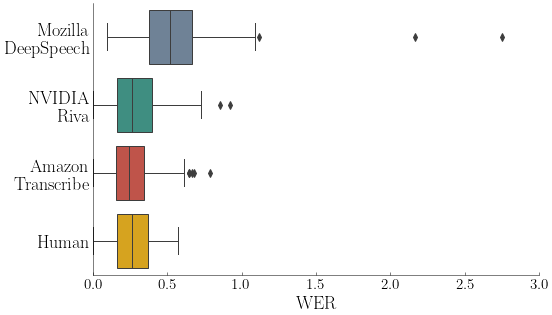

In [146]:
plt.figure(figsize=(8,5))

data = english_clips[[ "ds_wer", "riva_wer","aws_wer", "human2_wer"]]
data.columns = ["DeepSpeech", "Riva", "AWS", "Human2"]
data = data.melt(value_vars = ["DeepSpeech", "Riva", "AWS", "Human2"])
data.columns=["Model", "WER"]

ax = sns.boxplot(data=data, y='Model', x='WER')
# plt.title('Word Error Rate (WER) Distribution', size=16)
plt.ylabel('')
plt.xlabel('WER', size=18)
plt.xticks(size=15)
plt.yticks(ticks=[0,1,2,3], 
           labels=['Mozilla\nDeepSpeech', 'NVIDIA\nRiva', 'Amazon\nTranscribe', 'Human'],
           size=18
          )

# Remove spines
sns.despine(top=True, right=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)

plt.xlim(0,3)

# plt.show()
plt.savefig('img/WER_distribution.pdf', bbox_inches='tight') 
plt.savefig('img/WER_distribution.png', bbox_inches='tight') 


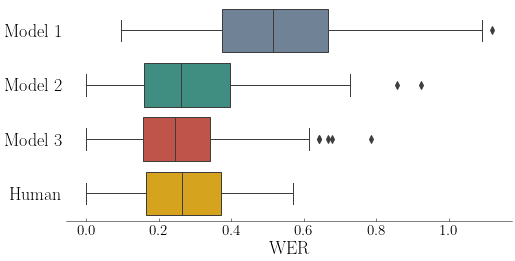

In [53]:
# THIS IS FOR THE BLOG POST ONLY
plt.figure(figsize=(8,4))

data = english_clips[[ "ds_wer", "riva_wer","aws_wer", "human2_wer"]]
data.columns = ["DeepSpeech", "Riva", "AWS", "Human2"]
data = data.melt(value_vars = ["DeepSpeech", "Riva", "AWS", "Human2"])
data.columns=["Model", "WER"]

# REMOVING OUTLIERS
data = data[data.WER < 2]

ax = sns.boxplot(data=data, y='Model', x='WER')
# plt.title('Word Error Rate (WER) Distribution', size=16)
plt.ylabel('')
plt.xlabel('WER', size=18)
plt.xticks(size=15)
plt.yticks(ticks=[0,1,2,3], 
           labels=['Model 1', 'Model 2', 'Model 3', 'Human'],
           size=18
          )

# Remove spines
sns.despine(top=True, right=True, left=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)

# plt.show()
# plt.savefig('img/blogpost_WER_distribution_anon.pdf', bbox_inches='tight') 
plt.savefig('img/blogpost_WER_distribution_anon.png', bbox_inches='tight') 


In [144]:
english_clips[["riva_wer", "ds_wer", "aws_wer", "human2_wer"]].describe()

,riva_wer,ds_wer,aws_wer,human2_wer
count,200.000000,199.000000,200.000000,200.000000
mean,0.286578,0.554533,0.258148,0.269570
std,0.165468,0.284887,0.151245,0.138670
min,0.000000,0.096774,0.000000,0.000000
25%,0.160000,0.375000,0.156250,0.165541
50%,0.260870,0.521739,0.245000,0.264912
75%,0.397170,0.666667,0.343054,0.371083
max,0.923077,2.750000,0.785714,0.571429


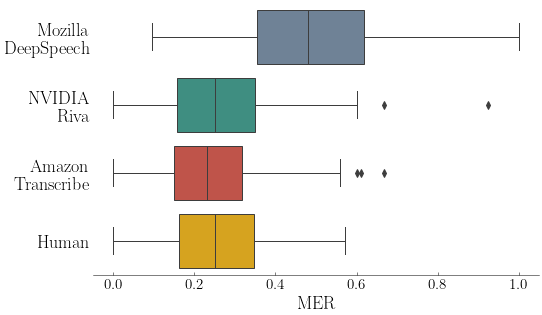

In [103]:
plt.figure(figsize=(8,5))

data = english_clips[[ "ds_mer", "riva_mer","aws_mer", "human2_mer"]]
data.columns = ["DeepSpeech", "Riva", "AWS", "Human2"]
data = data.melt(value_vars = ["DeepSpeech", "Riva", "AWS", "Human2"])
data.columns=["Model", "MER"]

ax = sns.boxplot(data=data, y='Model', x='MER')
plt.ylabel('')
plt.xlabel('MER', size=18)
plt.xticks(size=15)
plt.yticks(ticks=[0,1,2,3], 
           labels=['Mozilla\nDeepSpeech', 'NVIDIA\nRiva', 'Amazon\nTranscribe', 'Human'],
           size=18
          )

# Remove spines
sns.despine(top=True, right=True, left=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)


# plt.show()
plt.savefig('img/MER_distribution.pdf', bbox_inches='tight') 


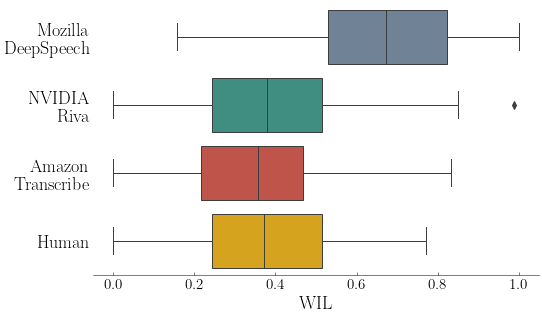

In [104]:
plt.figure(figsize=(8,5))

data = english_clips[[ "ds_wil", "riva_wil","aws_wil", "human2_wil"]]
data.columns = ["DeepSpeech", "Riva", "AWS", "Human2"]
data = data.melt(value_vars = ["DeepSpeech", "Riva", "AWS", "Human2"])
data.columns=["Model", "WIL"]

ax = sns.boxplot(data=data, y='Model', x='WIL')
plt.ylabel('')
plt.xlabel('WIL', size=18)
plt.xticks(size=15)
plt.yticks(ticks=[0,1,2,3], 
           labels=['Mozilla\nDeepSpeech', 'NVIDIA\nRiva', 'Amazon\nTranscribe', 'Human'],
           size=18
          )

# Remove spines
sns.despine(top=True, right=True, left=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)

# plt.show()
plt.savefig('img/WIL_distribution.pdf', bbox_inches='tight') 


### Other things not including in the paper (MER, MIL, histogram)

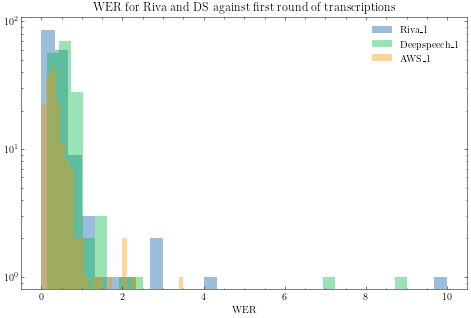

In [105]:
# Note this is jsut for first round of trans, bc second round is mostly null

nbins=30

plt.figure(figsize=(8,5))
plt.hist(english_clips["riva_1_wer"], label='Riva\_1', bins=nbins, alpha=0.4)
plt.hist(english_clips["ds_1_wer"], label='Deepspeech\_1', bins=nbins, alpha=0.4)
plt.hist(english_clips["aws_1_wer"], label='AWS\_1', bins=nbins, alpha=0.4)

# plt.xlim((-0.1,3))
plt.yscale('log')

plt.legend()
plt.xlabel('WER')
plt.title('WER for Riva and DS against first round of transcriptions')
plt.show()

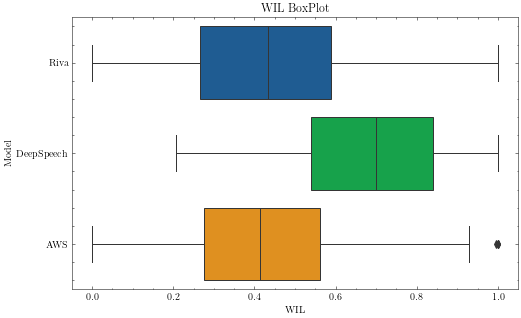

In [182]:
data = english_clips[["riva_1_wil", "ds_1_wil", "aws_1_wil"]]
data.columns = ["Riva", "DeepSpeech", "AWS"]
data = data.melt(value_vars = ["Riva", "DeepSpeech", "AWS"])
data.columns=["Model", "WIL"]

plt.figure(figsize=(8,5))
sns.boxplot(data=data, y='Model', x='WIL')
plt.title('WIL BoxPlot')
plt.show()

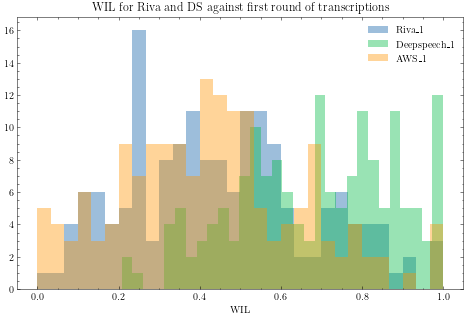

In [106]:
# Note this is jsut for first round of trans, bc second round is mostly null

nbins=30

plt.figure(figsize=(8,5))
plt.hist(english_clips["riva_1_wil"], label='Riva\_1', bins=nbins, alpha=0.4)
plt.hist(english_clips["ds_1_wil"], label='Deepspeech\_1', bins=nbins, alpha=0.4)
plt.hist(english_clips["aws_1_wil"], label='AWS\_1', bins=nbins, alpha=0.4)

plt.legend()
plt.xlabel('WIL')
plt.title('WIL for Riva and DS against first round of transcriptions')
plt.show()

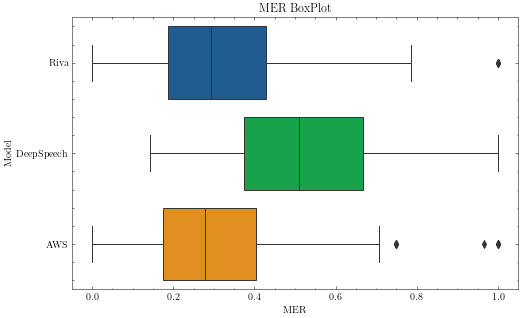

In [183]:
data = english_clips[["riva_1_mer", "ds_1_mer", "aws_1_mer"]]
data.columns = ["Riva", "DeepSpeech", "AWS"]
data = data.melt(value_vars = ["Riva", "DeepSpeech", "AWS"])
data.columns=["Model", "MER"]

plt.figure(figsize=(8,5))
sns.boxplot(data=data, y='Model', x='MER')
plt.title('MER BoxPlot')
plt.show()

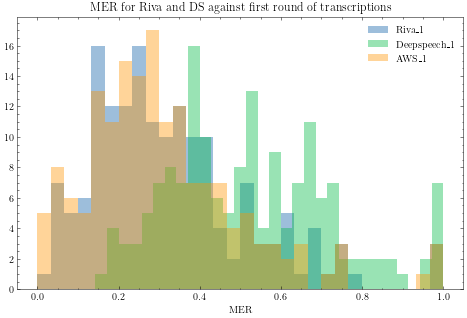

In [107]:
# Note this is jsut for first round of trans, bc second round is mostly null

nbins=30

plt.figure(figsize=(8,5))
plt.hist(english_clips["riva_1_mer"], label='Riva\_1', bins=nbins, alpha=0.4)
plt.hist(english_clips["ds_1_mer"], label='Deepspeech\_1', bins=nbins, alpha=0.4)
plt.hist(english_clips["aws_1_mer"], label='AWS\_1', bins=nbins, alpha=0.4)

plt.legend()
plt.xlabel('MER')
plt.title('MER for Riva and DS against first round of transcriptions')
plt.show()

### Another idea: keep only covid taxonomy words and do metric on it?
There may be a lot of empty strings bc a lot of these are not actually about covid

This may not actually be worth it and maybe WER is fine

In [149]:
t_cols = ["transcription_human1", "transcription_human2", 
          "transcription_riva", "transcription_aws", "transcription_deepspeech", ]

covid_words = ["covid", "corona", "vaccine", "vaccination", "pandemic", "quarantine", "virus", "disease",
               "clot", "infect"
              ]

# Less interesting words: "side effect", "delta", "variant"

In [180]:
covid_word_counts = []
for w in covid_words:
    # a subset of if human1 found the word 
    subset = english_clips[english_clips["transcription_human1"].str.contains(w)][t_cols]

    for t in t_cols:
        covid_word_counts.append({
            "word": w,
            "model": t.split("_")[1],
            "count": subset[t].str.count(w).sum()
        })
    

In [181]:
covid_word_counts_df = pd.DataFrame(covid_word_counts)


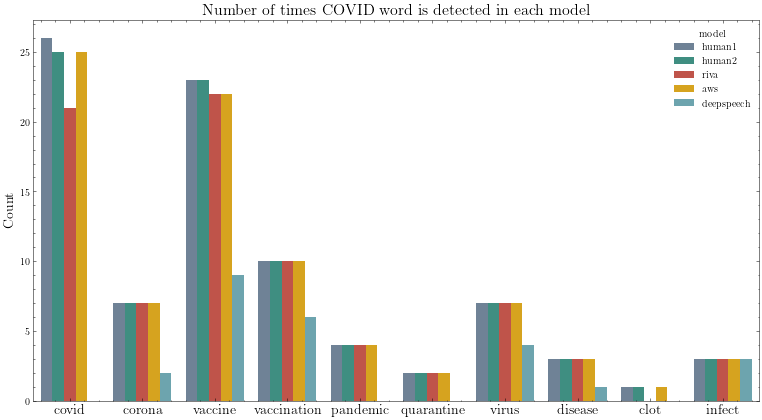

In [152]:
plt.figure(figsize=(13,7))
sns.barplot(data=covid_word_counts_df, x='word', y='count', hue='model')
plt.xticks(size=14)
plt.xlabel('')
plt.ylabel('Count', size=14)
plt.title('Number of times COVID word is detected in each model', size=16)
plt.show()

In [183]:
covid_word_counts_pivot = covid_word_counts_df.pivot(index='word', columns='model', values='count')
covid_word_counts_pivot.columns.name = None

ground_truth = covid_word_counts_pivot["human1"].values
covid_word_counts_pivot = covid_word_counts_pivot[["deepspeech", "riva", "aws", "human2"]]

In [184]:
covid_word_counts_pivot.apply(lambda x: x/ground_truth).T

word,clot,corona,covid,disease,infect,pandemic,quarantine,vaccination,vaccine,virus
deepspeech,0.0,0.285714,0.000000,0.333333,1.0,0.0,0.0,0.6,0.391304,0.571429
riva,0.0,1.000000,0.807692,1.000000,1.0,1.0,1.0,1.0,0.956522,1.000000
aws,1.0,1.000000,0.961538,1.000000,1.0,1.0,1.0,1.0,0.956522,1.000000
human2,1.0,1.000000,0.961538,1.000000,1.0,1.0,1.0,1.0,1.000000,1.000000


In [155]:
data = covid_word_counts_pivot.apply(lambda x: x/ground_truth).T

In [156]:
from IPython.core.display import display, HTML
output = data.to_html(formatters={
    'clot': '{:,.2%}'.format,
    'corona': '{:,.2%}'.format,
    'covid': '{:,.2%}'.format,
    'disease': '{:,.2%}'.format,
    'infect': '{:,.2%}'.format,
    'pandemic': '{:,.2%}'.format,
    'quarantine': '{:,.2%}'.format,
    'vaccination': '{:,.2%}'.format,
    'vaccine': '{:,.2%}'.format,
    'virus': '{:,.2%}'.format,
})
display(HTML(output))

word,clot,corona,covid,disease,infect,pandemic,quarantine,vaccination,vaccine,virus
deepspeech,0.00%,28.57%,0.00%,33.33%,100.00%,0.00%,0.00%,60.00%,39.13%,57.14%
riva,0.00%,100.00%,80.77%,100.00%,100.00%,100.00%,100.00%,100.00%,95.65%,100.00%
aws,100.00%,100.00%,96.15%,100.00%,100.00%,100.00%,100.00%,100.00%,95.65%,100.00%
human2,100.00%,100.00%,96.15%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%


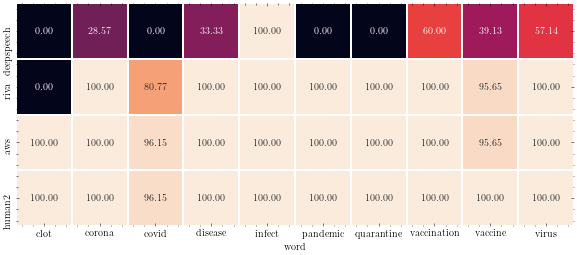

In [157]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(data, annot=True, fmt=".2%", square=1, linewidth=1., cbar=False)
plt.show()

# Radio statistics for the publication paper

In [2]:
# For unzipping zip file from Tomaz
# import shutil
# filename = '/home/ubuntu/online_relevant_clips.zip'
# shutil.unpack_archive(filename, '/home/ubuntu/')

import datetime
import pytz
from pytz import timezone

In [3]:
african_countries = ['algeria', 'benin', 'botswana', 'burkina_faso', 
                     'cameroon', 'democratic_republic_congo', 
                     'ghana', 'guinea', 'kenya', 'liberia', 
                     'madagascar', 'malawi', 'mauritius', 'namibia', 'nigeria', 
                     'republic_of_the_congo', 'rwanda', 'senegal', 'sierra_leone', 
                     'south_africa', 'togo', 'uganda', 'zambia', 'zimbabwe']

In [4]:
# Democratic Republic of Congo
# kinshasa - WAT
# bukavu - CAT
# goma - CAT

# Time zone compared to UTC
country2timezone = {
    'nigeria': 'WAT',
    'algeria': 'WAT',
    'benin': 'WAT',
    'cameroon': 'WAT',
    'republic_of_the_congo': 'WAT',
    'democratic_republic_congo': 'WAT',
    'ghana': 'GMT',
    'guinea': 'GMT',
    'burkina_faso': 'GMT',
    'liberia': 'GMT',
    'sierra_leone': 'GMT',
    'senegal': 'GMT',
    'togo': 'GMT',
    'south_africa': 'SAST',
    'botswana': 'CAT',
    'malawi': 'CAT',
    'namibia': 'CAT',
    'rwanda': 'CAT',
    'zimbabwe': 'CAT',
    'zambia': 'CAT',
    'kenya': 'EAT',
    'madagascar': 'EAT',
    'uganda': 'EAT',
    'mauritius': 'MUT',
    
}

# How many hours compared to UTC
timezone2utc = {
    'GMT': 0,
    'WAT': 1,
    'SAST': 2,
    'CAT': 2,
    'EAT': 3,
    'MUT': 4
}

In [5]:
df = pd.read_csv('online_relevant_clips.csv')

# Convert day to datetime object
df.day = pd.to_datetime(df.day)

# Just get the ones relevant for African countries
df = df[df.country.isin(african_countries)]

# Sort and order by country and date
df.sort_values(by=["country", "location", "name", "day"], inplace=True)
df.reset_index(inplace=True, drop=True)

# Combine "democratic_republic_of_the_congo" to all be "democratic_republic_congo"
df.loc[df.country.str.contains('democratic_republic_of_the_congo'), "country"] = "democratic_republic_congo"

# Get the full date and time as one column
df["datetime"] = df["clip"].apply(lambda x: re.search('\d\d\d\d-\d\d-\d\dT\d\d.\d\d.\d\d', x).group(0))
df["datetime"] = df["datetime"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H.%M.%S"))

# Set time zones
df["timezone"] = df.country.apply(lambda x: country2timezone[x])
# Kinshasa, Democratic Republic of the Congo --> actually in WAT
# Whereas Bukavu and Goma are in CAT
df.loc[df.location.str.contains('kinshasa'), "timezone"] = "WAT"

# local datetime
df["local_datetime"] = df.apply(lambda x: x.datetime + datetime.timedelta(hours=timezone2utc[x.timezone]), axis=1)

# Get the hour of the local datetime
df["local_hour"] = df.local_datetime.apply(lambda x: x.hour)

### Basic Exploration

In [6]:
len(df)

2043455

In [7]:
# What are the unique number of countries and stations?
df.country.nunique(), df.location.nunique()

(24, 45)

In [8]:
# Unique countries
df.country.unique()

array(['algeria', 'benin', 'botswana', 'burkina_faso', 'cameroon',
       'democratic_republic_congo', 'ghana', 'guinea', 'kenya', 'liberia',
       'madagascar', 'malawi', 'mauritius', 'namibia', 'nigeria',
       'republic_of_the_congo', 'rwanda', 'senegal', 'sierra_leone',
       'south_africa', 'togo', 'uganda', 'zambia', 'zimbabwe'],
      dtype=object)

In [9]:
df.day.min(), df.day.max()

(Timestamp('2020-04-20 00:00:00'), Timestamp('2021-11-05 00:00:00'))

In [10]:
# What are the unique stations per country?
unique_station_per_country = df.groupby('country')['name'].agg(['unique']).reset_index()
unique_station_per_country.columns = ["country", "unique_stations"]
unique_station_per_country["num_stations"] = unique_station_per_country.unique_stations.apply(lambda x: len(x))

In [11]:
unique_station_per_country.sort_values(by="num_stations", ascending=False)

,country,unique_stations,num_stations
8,kenya,"[WestFM, RadioIsukuti, NyaluoRadio, RadioSafar...",13
14,nigeria,"[OgunRadioFM, RootsFM, SweetFM, DunamisRadio, ...",12
19,south_africa,"[RosestadFM, HeartFM, RadioKCFM, StereoSonderG...",9
7,guinea,"[BonheurFM, DjomaFM, EspaceFM, FIMFM, Nostalgi...",8
21,uganda,"[89.2, 91.9, 92.7, 94.4, 95.5, 96.3]",6
12,mauritius,"[RadioPlus, Radio230, RadioOne, TopFM, WazaaFM]",5
13,namibia,"[EagleFM, Kosmos, OmulungaRadio]",3
3,burkina_faso,"[RadioLaVoixdesBale, RadioPulsar, SavaneFM]",3
6,ghana,"[NeatFM, PeaceFM, OmanFM]",3
16,rwanda,"[FlashFM, KTRadio, RadioRwanda]",3


In [12]:
# How many clips are there (overall) per country?
num_rec_per_country = df.groupby(['country'])['location'].count().reset_index()
num_rec_per_country.columns=["country", "count"]

In [13]:
# The top 6 countries we were getting recrodings for! So that is what we will benchmark
num_rec_per_country.sort_values(by='count', ascending=False)

,country,count
14,nigeria,212285
19,south_africa,180775
16,rwanda,160159
6,ghana,148699
8,kenya,131611
13,namibia,119804
7,guinea,112821
0,algeria,98973
12,mauritius,95316
1,benin,91246


### Figures for Paper

#### Figure 1 Left: Histogram of 5-minute clips by day

In [14]:
# Histogram of 5-minute segments in an average day
# THIS MIGHT BE SKEWED as some stations removed by Tomaz
num_clips_per_day = df.groupby('day')['clip'].count().reset_index()

# Group by number of stations per day
num_stations_per_day = df.groupby('day')['name'].unique().reset_index()
num_stations_per_day["num_stations"] = num_stations_per_day["name"].apply(lambda x: len(x))

# Dividing number of clips per day by number of stations there were for that day
num_clips_per_day["num_per_station"] = num_clips_per_day["clip"] / num_stations_per_day["num_stations"]

In [15]:
num_clips_per_day["num_per_station"].max()

288.0

In [16]:
num_clips_per_day["num_per_station"]

0        1.000000
1        8.666667
2        1.500000
3        1.000000
4        3.000000
          ...    
418    116.300000
419    111.387097
420    115.754098
421    118.300000
422    103.854839
Name: num_per_station, Length: 423, dtype: float64

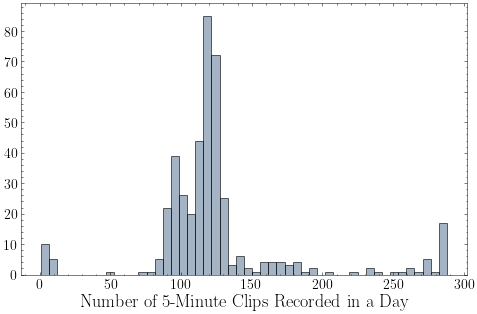

In [26]:
plt.figure(figsize=(8,5))
plt.hist(num_clips_per_day["num_per_station"].values, 50, alpha=0.6, edgecolor='black')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Number of 5-Minute Clips Recorded in a Day", size=18)
# plt.show()

plt.savefig('img/num_clips_per_day.pdf', bbox_inches='tight') 


#### Figure 1 Right: Number of recordings, aggregated by hour

In [20]:
# How many clips per hour? (Aggregating all stations and countries in Africa)
num_rec_by_hour = df.groupby(['local_hour'])['location'].count().reset_index()
num_rec_by_hour.columns=["local_hour", "count"]

In [21]:
num_rec_by_hour["count_norm"] = num_rec_by_hour["count"] / num_rec_by_hour["count"].sum() * 100

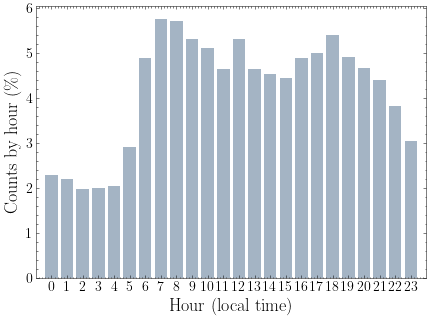

In [29]:
# Figure 1 Right
plt.figure(figsize=(8,5))
plt.bar(x=num_rec_by_hour['local_hour'], height=num_rec_by_hour['count_norm'], alpha=0.6)
plt.ylabel('Counts by hour (\%)', size=18)
plt.yticks(size=14)
plt.xlabel('Hour (local time)', size=18)
plt.xticks(range(0,24), size=14)
plt.xlim(-1,24)
# plt.show()

plt.savefig('img/num_clips_per_hour.pdf', bbox_inches='tight') 


(figure 1 right) gives more context to figure 1 left

24*12 = 288
Probability of how many clips you will find in a given day


Text(0.5, 1.0, 'How many clips recorded (agg across all countries) per day?')

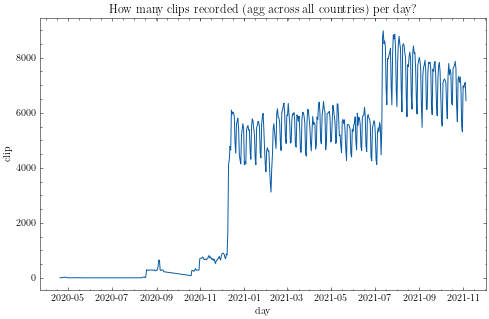

In [118]:
plt.figure(figsize=(8,5))

sns.lineplot(data=num_clips_per_day, x='day', y='clip')
plt.title('How many clips recorded (agg across all countries) per day?')

In [228]:
df.groupby(['day', 'name'])['clip'].count().reset_index()

,day,name,clip
0,2020-04-20,96.3,1
1,2020-04-28,94.4,2
2,2020-04-28,95.5,11
3,2020-04-28,96.3,13
4,2020-04-30,95.5,2
...,...,...,...
19838,2021-11-05,WazobiaFM,171
19839,2021-11-05,WestFM,155
19840,2021-11-05,Yanasalam,39
19841,2021-11-05,ZNBCR1,145


# Privacy?

Because we don't have a ground-truth for NER, hard to know what is the right amount of privacy or not.

In [5]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities.engine import RecognizerResult, OperatorConfig
from collections import Counter
from collections import defaultdict 
from nltk.tokenize import sent_tokenize, word_tokenize
import re, json

In [6]:
# pip install presidio-analyzer
# pip install presidio-anonymizer
# python -m spacy download en_core_web_sm

In [7]:
# Initialize the engine with logger.
anonymizer = AnonymizerEngine()
analyzer = AnalyzerEngine()

In [8]:
# By Sasha

# Need to add more to vaxlist

def find_vaccines(text):
    vaccines = Counter()
    vaxlist=['Pfizer', 'Moderna', 'Janssen', 'Astra', 'Zeneca', 'Zenica', 'AstraZeneca', 'Astrazeneca', 'Oxford','Johnson'
            'COVAX', 'Omicron', 'Covidex', 'Covilyce', 'Covid', 'Moderna']
    for word in vaxlist:
        text=re.sub(word, '*'+word+'*', text, flags=re.I)
    return(text)



def get_anonymized(doc):
    """
        If we want to return the text with the PII replaced
    """
    anonresult = anonymizer.anonymize(doc, analyzer.analyze(text=doc,
                               entities=entlist,
                               language='en'))
    final=json.loads(anonresult.to_json())
    return final['text']


def get_anonymized_entities(doc):
    """
        returns the PII entities being replaced
    """
    if len(doc) == 0:
        return []
    
    doc = find_vaccines(doc)
    
    anonresult = anonymizer.anonymize(doc, analyzer.analyze(text=doc,
                               entities=entlist,
                               language='en'))
    final=json.loads(anonresult.to_json())
    return [i['entity_type'] for i in final['items']]

def get_detected_entites(doc):
    """ Just run the analyzer """
    if len(doc) == 0:
        return []
    doc = find_vaccines(doc)
    analyzer_result = analyzer.analyze(text=doc, entities=entlist, language='en')
    
    return [doc[i.start:i.end] for i in analyzer.analyze(text=doc, entities=entlist, language='en')]

def get_detected_entity_types(doc):
    """ Just run the analyzer """
    if len(doc) == 0:
        return []
    doc = find_vaccines(doc)
    analyzer_result = analyzer.analyze(text=doc, entities=entlist, language='en')
    
    return [i.entity_type for i in analyzer.analyze(text=doc, entities=entlist, language='en')]


In [9]:
entlist=["PERSON", "PHONE_NUMBER", "NRP", "LOCATION"]

### On the transcriptons

In [48]:
english_clips["pii_human1"] = english_clips["transcription_human1"].apply(get_detected_entites)
english_clips["pii_human2"] = english_clips["transcription_human1"].apply(get_detected_entites)
english_clips["pii_riva"] = english_clips["transcription_riva"].apply(get_detected_entites)
english_clips["pii_deepspeech"] = english_clips["transcription_deepspeech"].apply(get_detected_entites)
english_clips["pii_aws"] = english_clips["transcription_aws"].apply(get_detected_entites)

In [49]:
english_clips["pii_types_human1"] = english_clips["transcription_human1"].apply(get_detected_entity_types)
english_clips["pii_types_human2"] = english_clips["transcription_human2"].apply(get_detected_entity_types)
english_clips["pii_types_riva"] = english_clips["transcription_riva"].apply(get_detected_entity_types)
english_clips["pii_types_deepspeech"] = english_clips["transcription_deepspeech"].apply(get_detected_entity_types)
english_clips["pii_types_aws"] = english_clips["transcription_aws"].apply(get_detected_entity_types)



In [50]:
# A df of the piis found and removed in the transcriptions
pii_df = english_clips[["pii_riva", "pii_deepspeech", "pii_aws", "pii_human1", "pii_human2",
                       "pii_types_riva", "pii_types_deepspeech", "pii_types_aws", "pii_types_human1", "pii_types_human2"
                       ]]

In [51]:
for c in pii_df.columns:
    pii_df[f"{c}_len"] = pii_df[c].apply(len)

In [52]:
pii_df.to_csv('pii_df.csv', index=False)

In [53]:
# pii_df = pd.read_csv('pii_df.csv')

In [54]:
# RIVA types counter
riva_pii = Counter([a for sublist in pii_df["pii_types_riva"] for a in sublist]).most_common()

In [55]:
# Deepspeech counter
ds_pii = Counter([a for sublist in pii_df["pii_types_deepspeech"] for a in sublist]).most_common()

In [56]:
# AWS counter
aws_pii = Counter([a for sublist in pii_df["pii_types_aws"] for a in sublist]).most_common()

In [57]:
# Human transcription 1 counter
human1_pii = Counter([a for sublist in pii_df["pii_types_human1"] for a in sublist]).most_common()

In [58]:
# Human transcription 1 counter
human2_pii = Counter([a for sublist in pii_df["pii_types_human2"] for a in sublist]).most_common()

In [59]:
pii_df_2 = pd.DataFrame([riva_pii, ds_pii, aws_pii, human1_pii, human2_pii])
pii_df_2.columns=['Location', 'Person', 'NRP', 'Phone Number']
pii_df_2 = pii_df_2.fillna(0)

In [70]:
pii_df_2

,Location,Person,NRP,Phone Number
Riva,69,54,18,0
DS,37,33,13,0
Amazon,75,49,25,3
Human1,64,27,23,2
Human2,62,39,25,3


In [60]:
def extract_count(row):
    if row != 0:
        w,c = row
        return c
    else: return 0
    
pii_df_2 = pii_df_2.applymap(lambda x: extract_count(x))
pii_df_2.index = ["Riva", "DS", "Amazon", "Human1", "Human2"]


In [61]:
def get_perc_diff(x):
    return (x - pii_df_2.loc['Human1'])/pii_df_2.loc['Human1']

pii_percent_diff = pii_df_2.apply(get_perc_diff, axis=1)
pii_percent_diff = pii_percent_diff.loc[["DS", "Riva", "Amazon", "Human2"]].reset_index()
pii_percent_diff = pii_percent_diff.melt(id_vars='index')
pii_percent_diff.columns=['model', 'variable', 'p_change']

In [63]:
pii_percent_diff["p_change"] * 100

0     -42.187500
1       7.812500
2      17.187500
3      -3.125000
4      22.222222
5     100.000000
6      81.481481
7      44.444444
8     -43.478261
9     -21.739130
10      8.695652
11      8.695652
12   -100.000000
13   -100.000000
14     50.000000
15     50.000000
Name: p_change, dtype: float64

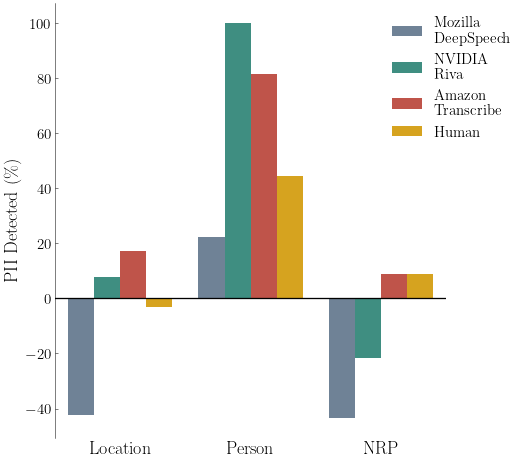

In [68]:
data = pii_percent_diff[pii_percent_diff.variable != 'Phone Number']
data["p_change"] = data["p_change"] * 100


plt.figure(figsize=(7,8))
ax = sns.barplot(data=data, 
                 x='variable', y='p_change', hue='model')
plt.xlabel('', size=18)

plt.xticks(size=18)
plt.yticks(size=15)
plt.ylabel('PII Detected (\%)', size=18)

handles, labels = ax.get_legend_handles_labels()

# Remove spines
sns.despine(top=True, right=True, bottom=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False, bottom=False)
# Remove the ticks on the y axis
# plt.tick_params(left = False)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.3)

plt.legend(title_fontsize=16, 
           fontsize=15, 
           title='', 
           ncol=1,
           handles=handles,
           labels=['Mozilla\nDeepSpeech', 'NVIDIA\nRiva', 'Amazon\nTranscribe', 'Human'],
           loc='upper right',
           bbox_to_anchor=(1.2,1)
          )

plt.savefig('img/privacy_presidio_results.pdf', bbox_inches='tight') 
# plt.savefig('img/privacy_presidio_results.png', bbox_inches='tight') 





# The DeepSpeech dashboard

In [5]:
import os
import csv
import pandas as pd
import re

In [6]:
# The CSVs that Isaiah got
CSV_DIR = '/efs-who/100-random-clips-transcriptions/radio_clips/'

# Where to put the texts
OUT_DIR = '/efs-who/big_volume/textsnew_deepspeech'
# Of form antalaha.RadioRNAAntalaha_2021-02-21T03.15.01.mp3.transcription.txt

In [7]:
errors = []
for city in os.listdir(CSV_DIR):
    if city not in ['cape_town', 'durban', 'antalaha', 'ibadan', 'johannesburg', 'lagos']:
        continue
    city_path = os.path.join(CSV_DIR, city)
    for date in os.listdir(city_path):
        date_path = os.path.join(city_path, date)
        for csv_file in os.listdir(date_path):
            csv_path = os.path.join(date_path, csv_file)
#             print(csv_path)

            try:
                # Open the CSV and capture the deepspeech transcription
                with open(os.path.join(csv_path)) as fn:
                    data = csv.reader(fn)
                    row = list(data)[1]
                    deepspeech_transcript = row[2]
            except IndexError:
                print(f"Index error for {csv_file}")
                # Keep track of the errors
                errors.append(csv_path)
                continue
                
            # New filename where we want to output the txt file
            csv_file_edited = re.sub("csv", "mp3", csv_file)
            new_filename = f"{city}.{csv_file_edited}.transcription.txt"
            out_filepath = os.path.join(OUT_DIR, new_filename)

            # Write to the new text file
            with open(out_filepath, 'w') as f:
                f.write(deepspeech_transcript)
                

In [13]:
aws_files = os.listdir('/efs-who/big_volume/textsnew')

In [18]:
aws_files

['antalaha.RadioRNAAntalaha_2021-04-13T13.45.01.mp3.transcription.txt',
 'johannesburg.702Talk_2021-04-10T00.45.01.mp3.transcription.txt',
 'capetown.CapeTalk_2021-02-22T13.45.01.mp3.transcription.txt',
 'capetown.CapeTalk_2021-03-02T15.35.01.mp3.transcription.txt',
 'lagos.NigeriaInfoLagos_2021-03-13T03.35.01.mp3.transcription.txt',
 'durban.VumaFM_2021-02-25T14.20.02.mp3.transcription.txt',
 'johannesburg.702Talk_2021-04-15T01.30.01.mp3.transcription.txt',
 'ibadan.FreshFM_2021-04-12T04.40.01.mp3.transcription.txt',
 'johannesburg.702Talk_2021-04-01T23.40.01.mp3.transcription.txt',
 'johannesburg.702Talk_2021-03-21T21.50.01.mp3.transcription.txt',
 'capetown.CapeTalk_2021-03-24T12.25.01.mp3.transcription.txt',
 'capetown.CapeTalk_2021-03-24T09.10.01.mp3.transcription.txt',
 'capetown.CapeTalk_2021-04-09T15.00.01.mp3.transcription.txt',
 'ibadan.FreshFM_2021-04-17T18.55.01.mp3.transcription.txt',
 'capetown.CapeTalk_2021-03-29T13.10.01.mp3.transcription.txt',
 'antalaha.RadioRNAAntala

In [14]:
deepspeech_files = os.listdir(OUT_DIR)
    

In [23]:
len(set(aws_files) - set(deepspeech_files))

61175

In [24]:
deepspeech_files

['cape_town.CapeTalk_2021-04-04T07.15.0.mp3.transcription.txt',
 'lagos.NigeriaInfoLagos_2021-03-06T15.40.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-02-25T18.20.01.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-04-09T11.15.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-02-25T21.35.01.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-04-09T08.00.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-03-29T06.10.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-02-22T06.45.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-03-02T08.35.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-02-27T10.45.0.mp3.transcription.txt',
 'cape_town.CapeTalk_2021-02-27T07.30.0.mp3.transcription.txt',
 'durban.VumaFM_2021-03-19T03.20.0.mp3.transcription.txt',
 'lagos.LagosTalks_2021-04-05T23.10.0.mp3.transcription.txt',
 'durban.VumaFM_2021-03-22T18.20.0.mp3.transcription.txt',
 'johannesburg.702Talk_2021-02-23T14.30.0.mp3.transcription.txt',
 'johannesburg.702Talk_2021-03-03T16.20.0.mp

In [16]:
len(aws_files), len(deepspeech_files)

(61175, 40676)

In [17]:
for city in os.listdir(CSV_DIR):
    if city not in ['cape_town', 'durban', 'antalaha', 'ibadan', 'johannesburg', 'lagos']:
        continue
    city_path = os.path.join(CSV_DIR, city)
    for date in os.listdir(city_path):
        date_path = os.path.join(city_path, date)
        print(city, len(os.listdir(date_path)))
#         for csv_file in os.listdir(date_path):
#             csv_path = os.path.join(date_path, csv_file)

cape_town 297
cape_town 564
cape_town 504
cape_town 532
cape_town 376
cape_town 554
cape_town 570
cape_town 296
cape_town 195
cape_town 280
cape_town 279
cape_town 182
cape_town 177
cape_town 277
cape_town 274
cape_town 278
cape_town 275
cape_town 271
cape_town 282
cape_town 277
cape_town 162
cape_town 282
cape_town 280
cape_town 281
cape_town 138
cape_town 133
cape_town 281
cape_town 284
cape_town 171
cape_town 283
cape_town 284
cape_town 284
cape_town 274
cape_town 270
cape_town 286
cape_town 173
cape_town 171
cape_town 272
cape_town 141
cape_town 276
cape_town 285
cape_town 280
cape_town 283
cape_town 283
cape_town 283
cape_town 145
cape_town 147
cape_town 284
cape_town 282
cape_town 179
cape_town 272
cape_town 273
cape_town 283
cape_town 181
cape_town 145
cape_town 260
durban 51
durban 138
durban 130
durban 102
durban 77
durban 130
durban 121
durban 64
durban 58
durban 120
durban 109
durban 77
durban 84
durban 102
durban 114
durban 115
durban 108
durban 111
durban 124
durban 144
du

In [16]:
pd.read_csv('/efs-who/100-random-clips-transcriptions/radio_clips/cape_town/2021-03-15/CapeTalk_2021-03-15T06.35.01.csv')



EmptyDataError: No columns to parse from file

In [18]:
re.sub("csv", "mp3", "cape_town.CapeTalk_2021-03-06T07.30.0.csv")

'cape_town.CapeTalk_2021-03-06T07.30.0.mp3'

In [48]:
with open('/efs-who/big_volume/textsnew_deepspeech.txt', 'r') as f:
    ds = f.readlines()
with open('/efs-who/big_volume/textsnew_aws.txt', 'r') as f:
    aws = f.readlines()

In [52]:
len(set(ds) - set(aws))

38771

In [345]:
# Finding the ones with errors
errors = []
for city in os.listdir(CSV_DIR):
    city_path = os.path.join(CSV_DIR, city)
    for date in os.listdir(city_path):
        date_path = os.path.join(city_path, date)
        for csv_file in os.listdir(date_path):
            csv_path = os.path.join(date_path, csv_file)
#             print(csv_path)

            try:
                # Open the CSV and capture the deepspeech transcription
                with open(os.path.join(csv_path)) as fn:
                    data = csv.reader(fn)
                    row = list(data)[1]
                    deepspeech_transcript = row[2]
            except IndexError:
                errors.append(csv_path)
                
            

In [346]:
len(errors)

1067

In [59]:
with open("/efs-who/100-random-clips-transcriptions/radio_clips/files_with_errors.txt", 'w') as f:
    f.writelines(errors)
        

# Uganda and Omicron

## Covidex/Covilyce

In [44]:
import glob

In [65]:
UGANDA_DIR  = '/efs-who/data/yennie/plk-data/texts'
columns = ['file','text']
uganda_df = pd.DataFrame(columns=columns)

for txtf in glob.glob(f"{UGANDA_DIR}/*.txt"):
    with open(txtf, "r") as text_file:
        text = text_file.read()
        data = [[txtf, text]]
        one_df = pd.DataFrame(data, columns=columns)
        uganda_df = uganda_df.append(one_df, ignore_index=True)

In [66]:
def clean_transcriptions(t):
    """
        Cleans transcriptions by removing punctuation and digits, lowercasing,
        and replacing common misspellings or mis-transcriptions of COVID related
        words (astrazeneca, johnson, covax). Further, it combines certain
        tokens into one phrase (i.e., blood clot -> blood_clot)
        
        Note: This returns a string, not tokenized
    """
    text = str(t)
    
    # Lowercase
    text = text.lower()
    # Keep all alphanumeric characters (including digits)
    text = re.sub(r'[^\w\s]','',text)
    # Remove digits, keep only alphabet characters
    text = re.sub(r'\w*\d+\w*', '', text)
    # Remove multiple spaces in a row with one space
    text = re.sub(r'\s\s+', ' ', text)
    
    # Tokenize Johnson and Johnson and its variations
    text = re.sub(r'(johnson and johnson)|jnj', 'johnson_johnson', text)
    # Tokenize astrazeneca and its variations
    text = re.sub(r'(astra zeneca)|astrazenecas', 'astrazeneca', text)
    # Tokenize COVAX and its variations
    text = re.sub(r'corvex|kovacs|kovac', 'covax', text)
    # A mistake in the transcription
    text = re.sub(r'gon na', 'gonna', text)
    
    # Pre-doing some bad lemma things
    text = re.sub(r'suspension|suspending', 'suspend', text)
    text = re.sub(r'pausing', 'pause', text)
    text = re.sub(r'vaccination', 'vaccinate', text)
    text = re.sub(r'inoculation', 'inoculate', text)
    text = re.sub(r'pregnancy', 'pregnant', text)
    text = re.sub(r'miscarry', 'miscarriage', text)
    text = re.sub(r'vomiting', 'vomit', text)
    text = re.sub(r'nauseous', 'nausea', text)
    text = re.sub(r'received|receiving', 'receive', text)
    text = re.sub(r'inequitable', 'inequity', text)

    return text

In [67]:
uganda_df["clean_transcription"] = uganda_df.text.apply(clean_transcriptions)
uganda_df['date'] = uganda_df.file.str.extract('_(.{,10})')


In [68]:
uganda_df.head()

,file,text,clean_transcription,date
0,/efs-who/data/yennie/plk-data/texts/kampala.98...,--P1: They told him he had typhoid not malaria...,they told him he had typhoid not malaria i to...,2021-07-14
1,/efs-who/data/yennie/plk-data/texts/kampala.10...,[...]\nM1: Uganda has once again run out of th...,uganda has once again run out of the vaccine ...,2021-08-19
2,/efs-who/data/yennie/plk-data/texts/kampala.10...,M1: The heads of hospitals in different distri...,the heads of hospitals in different districts...,2021-09-16
3,/efs-who/data/yennie/plk-data/texts/kampala.10...,"--P1: At Busega round about, there are some po...",at busega round about there are some police o...,2021-08-16
4,/efs-who/data/yennie/plk-data/texts/kampala.10...,M1: The general public has been warned against...,the general public has been warned against mo...,2021-09-27


In [71]:
#add the column for the number of transcriptions per day
df_count = uganda_df.groupby("date").count().reset_index().drop(columns = ["file"], axis=1).rename(columns = {"text":"count_transcription"})
uganda_df = uganda_df.merge(df_count, on=["date"])
uganda_df = uganda_df.drop(columns = ['file', 'text', 'clean_transcription_y'], axis=1) 
uganda_df.head()

,clean_transcription_x,date,count_transcription
0,they told him he had typhoid not malaria i to...,2021-07-14,19
1,in the process of trying to secure the vaccin...,2021-07-14,19
2,the chairman of nyendo mukungwe in masaka cit...,2021-07-14,19
3,there are those who have made it a habit and ...,2021-07-14,19
4,inmates in kwania government prison tested po...,2021-07-14,19


In [149]:
#restrict dataset to ones including specific substrings
df_uganda = uganda_df.loc[uganda_df['clean_transcription_x'].str.contains("herbal treatment|herbal medicine|remedy|remedies|herbal drug|covidex|codivex|covilyce|covilyce-1|covylice|codivex|covylice", case=False)]
df_uganda.head()

,clean_transcription_x,date,count_transcription
16,a group of ugandan lawyers has taken nda to c...,2021-07-14,19
112,what final package do you leave for the liste...,2021-07-29,18
197,the president insisted that many of our peopl...,2021-07-31,14
224,talking about the corona my concern about thi...,2021-09-25,12
269,i have receive a message from a listener text...,2021-07-27,21


In [150]:
#number of words per clean transcription
df_uganda['word_count'] = df_uganda['clean_transcription_x'].str.split().str.len()
df_uganda.head()

,clean_transcription_x,date,count_transcription,word_count
16,a group of ugandan lawyers has taken nda to c...,2021-07-14,19,72
112,what final package do you leave for the liste...,2021-07-29,18,178
197,the president insisted that many of our peopl...,2021-07-31,14,150
224,talking about the corona my concern about thi...,2021-09-25,12,210
269,i have receive a message from a listener text...,2021-07-27,21,63


In [151]:
#restrict dataset to covid
df_uganda = df_uganda.loc[df_uganda['clean_transcription_x'].str.contains("coronavirus|covid|sars cov 2|corona virus|covid 19|cov 19|covid nineteen|corona|covid-19", case=False)]
df_uganda.head()

,clean_transcription_x,date,count_transcription,word_count
16,a group of ugandan lawyers has taken nda to c...,2021-07-14,19,72
197,the president insisted that many of our peopl...,2021-07-31,14,150
224,talking about the corona my concern about thi...,2021-09-25,12,210
269,i have receive a message from a listener text...,2021-07-27,21,63
406,do you have any medicine that helps with the ...,2021-07-28,26,157


In [152]:
#number of keywords per clean transcription
df_uganda['covidex'] = df_uganda.clean_transcription_x.str.count("covidex|codivex|codivex")
df_uganda['covilyce'] = df_uganda.clean_transcription_x.str.count("covilyce|covilyce-1|covylice")
df_uganda.head()

,clean_transcription_x,date,count_transcription,word_count,covidex,covilyce
16,a group of ugandan lawyers has taken nda to c...,2021-07-14,19,72,1,0
197,the president insisted that many of our peopl...,2021-07-31,14,150,1,0
224,talking about the corona my concern about thi...,2021-09-25,12,210,0,0
269,i have receive a message from a listener text...,2021-07-27,21,63,2,0
406,do you have any medicine that helps with the ...,2021-07-28,26,157,1,0


In [154]:
df_uganda.sum()

clean_transcription_x     a group of ugandan lawyers has taken nda to c...
date                     2021-07-142021-07-312021-09-252021-07-272021-0...
count_transcription                                                    256
word_count                                                            2959
covidex                                                                 22
covilyce                                                                 4
dtype: object

In [92]:
df_uganda = df_uganda.groupby('date').sum().reset_index()

# Normalized count
df_uganda["norm_count_covidex"] = df_uganda["covidex"]/df_uganda["word_count"]
df_uganda["norm_count_covilyce"] = df_uganda["covilyce"]/df_uganda["word_count"]

df_uganda.head()

,date,count_transcription,word_count,covidex,covilyce,norm_count_covidex,norm_count_covilyce
0,2021-07-09,15,128,3,0,0.023438,0.000000
1,2021-07-10,10,257,2,0,0.007782,0.000000
2,2021-07-12,9,283,1,0,0.003534,0.000000
3,2021-07-14,19,72,1,0,0.013889,0.000000
4,2021-07-15,28,333,1,3,0.003003,0.009009


In [93]:
df_uganda = df_uganda.set_index('date')
df_uganda.index = pd.to_datetime(df_uganda.index)
df_uganda = df_uganda.resample('D').sum()

In [107]:
uganda_dates = sorted(df_uganda.index)

covidex_vaccine_counts = df_uganda['norm_count_covidex'].rolling(7, min_periods=1, win_type='triang').sum()
covilyce_vaccine_counts = df_uganda['norm_count_covilyce'].rolling(7, min_periods=1, win_type='triang').sum()
covidex_vaccine_counts.name='Covidex'
covilyce_vaccine_counts.name = 'Covilyce'

# set the dates as index
# covidex_vaccine_counts.index=uganda_dates
# covilyce_vaccine_counts.index=uganda_dates

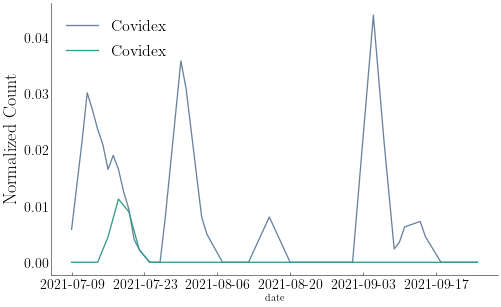

In [132]:
plt.figure(figsize=(8,5))
sns.lineplot(data=covidex_vaccine_counts.reset_index(), y='Covidex', x='date', label='Covidex',linewidth=1.3)
sns.lineplot(data=covilyce_vaccine_counts.reset_index(), y='Covilyce', x='date', label='Covidex',linewidth=1.3)


plt.ylabel('Normalized Count', size=18)

plt.legend(fontsize=16, loc='upper left')

ax = plt.gca()

# Remove spines
sns.despine(top=True, right=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False)

# print(ax.get_xticklabels())

# Set every  four dates on the x axis
# ax.set_xticks(np.arange(0, uganda_dates, 4))
ax.set_xticks(uganda_dates[::14])

# Larger tick values
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

plt.savefig('img/covidex_freq_plot.pdf', bbox_inches='tight') 
plt.show()


## Omicron

In [133]:
import os

In [134]:
def clean_transcriptions(t):
    """
        Cleans transcriptions by removing punctuation and digits, lowercasing,
        and replacing common misspellings or mis-transcriptions of COVID related
        words (astrazeneca, johnson, covax). Further, it combines certain
        tokens into one phrase (i.e., blood clot -> blood_clot)
        
        Note: This returns a string, not tokenized
    """
    text = str(t)
    
    # Lowercase
    text = text.lower()
    # Keep all alphanumeric characters (including digits)
    text = re.sub(r'[^\w\s]','',text)
    # Remove digits, keep only alphabet characters
    text = re.sub(r'\w*\d+\w*', '', text)
    # Remove multiple spaces in a row with one space
    text = re.sub(r'\s\s+', ' ', text)
    
    # Tokenize Johnson and Johnson and its variations
    text = re.sub(r'(johnson and johnson)|jnj', 'johnson_johnson', text)
    # Tokenize astrazeneca and its variations
    text = re.sub(r'(astra zeneca)|astrazenecas', 'astrazeneca', text)
    # Tokenize COVAX and its variations
    text = re.sub(r'corvex|kovacs|kovac', 'covax', text)
    # A mistake in the transcription
    text = re.sub(r'gon na', 'gonna', text)
    
    # Pre-doing some bad lemma things
    text = re.sub(r'suspension|suspending', 'suspend', text)
    text = re.sub(r'pausing', 'pause', text)
    text = re.sub(r'vaccination', 'vaccinate', text)
    text = re.sub(r'inoculation', 'inoculate', text)
    text = re.sub(r'pregnancy', 'pregnant', text)
    text = re.sub(r'miscarry', 'miscarriage', text)
    text = re.sub(r'vomiting', 'vomit', text)
    text = re.sub(r'nauseous', 'nausea', text)
    text = re.sub(r'received|receiving', 'receive', text)
    text = re.sub(r'inequitable', 'inequity', text)

    return text

In [136]:
omicron_transcriptions = []
TEXT_DIR = '/efs-who/data/yennie/texts-partitioned'
for city in os.listdir(TEXT_DIR):
    print(city)
    if city=='antalaha': continue
    
    city_dir = os.path.join(TEXT_DIR, city)
    for date in os.listdir(city_dir):
        # restrict dataset to October 31, 2021 to December 13, 2021
        if date > '2021-12-13':
            continue
            
        date_dir = os.path.join(city_dir, date)
        
        for txtf in os.listdir(date_dir):
            with open(os.path.join(date_dir, txtf), "r") as text_file:
                text = text_file.read()
                omicron_transcriptions.append({
                    "date": date,
                    "city": city,
                    "text": text
                })


cape_town
durban
antalaha
johannesburg
lagos
ibadan


In [137]:
omicron_df = pd.DataFrame(omicron_transcriptions)

In [138]:
# Clean the transcription by replacing (it is still a string) 
omicron_df["clean_transcription"] = omicron_df.text.apply(clean_transcriptions)

In [139]:
city2country = {"cape_town": "South Africa",
                "durban": "South Africa",
                "johannesburg": "South Africa",
                "lagos": "Nigeria",
                "ibadan": "Nigeria"
               }
omicron_df["country"] = omicron_df["city"].apply(lambda x: city2country[x])

In [140]:
# Locate words
df_omicron = omicron_df.loc[omicron_df['clean_transcription'].str.contains("omicron|omiclon|omikron|unicron|acron", case=False)]

# Set date as proper dtype
df_omicron.date = pd.to_datetime(df_omicron.date)

# Remove duplicates
df_omicron = df_omicron.drop_duplicates()


In [141]:
df_omicron['word_count'] = df_omicron['clean_transcription'].str.split().str.len()
df_omicron['omicron'] = df_omicron.clean_transcription.str.count("omicron|omiclon|omikron|unicron|acron")

# Count
df_omicron_count = df_omicron.groupby(['date']).sum().reset_index()

# Normalized count
df_omicron_count["norm_count_omicron"] = df_omicron_count["omicron"]/df_omicron_count["word_count"]
df_omicron_count.head()

,date,word_count,omicron,norm_count_omicron
0,2021-11-01,2937,5,0.001702
1,2021-11-02,2321,3,0.001293
2,2021-11-03,3405,6,0.001762
3,2021-11-04,732,1,0.001366
4,2021-11-05,974,2,0.002053


In [142]:
# Count
df_omicron_count_single = df_omicron.groupby(['date']).sum().reset_index()

# Normalized count
df_omicron_count_single["norm_count_omicron"] = df_omicron_count_single["omicron"]/df_omicron_count_single["word_count"]
df_omicron_count_single.head()

,date,word_count,omicron,norm_count_omicron
0,2021-11-01,2937,5,0.001702
1,2021-11-02,2321,3,0.001293
2,2021-11-03,3405,6,0.001762
3,2021-11-04,732,1,0.001366
4,2021-11-05,974,2,0.002053


In [143]:
omicron_dates = [t.date().strftime('%Y-%m-%d') for t in pd.date_range('2021-11-01', '2021-12-13').tolist()]

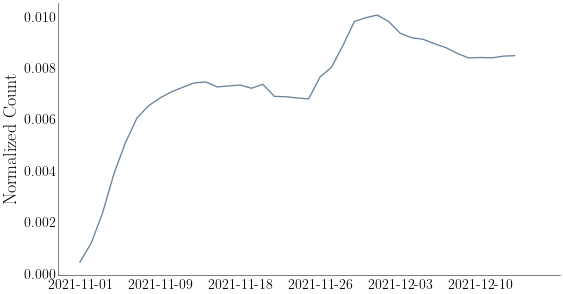

In [165]:
plt.figure(figsize=(9,5))
plt.plot(omicron_counts.index, omicron_counts.values, label='Omicron', linewidth=1.3)

plt.ylabel('Normalized Count', size=18)

# plt.legend(fontsize=16, loc='upper left')

ax = plt.gca()

# Remove spines
sns.despine(top=True, right=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False, bottom=False)

# print(ax.get_xticklabels())

# Set every  four dates on the x axis
ax.set_xticks(np.arange(0, len(omicron_dates), 7))
# ax.set_xticks(omicron_dates[::10])


# Larger tick values
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# plt.show()
plt.savefig('img/omicron_freq_plot.pdf', bbox_inches='tight') 


In [166]:
# SEPARATE BY COUNTRY

# Count
df_omicron_count = df_omicron.groupby(['date', 'country']).sum().reset_index()

# Normalized count
df_omicron_count["norm_count_omicron"] = df_omicron_count["omicron"]/df_omicron_count["word_count"]
df_omicron_count.head()

,date,country,word_count,omicron,norm_count_omicron
0,2021-11-01,Nigeria,1548,3,0.001938
1,2021-11-01,South Africa,1389,2,0.001440
2,2021-11-02,Nigeria,828,1,0.001208
3,2021-11-02,South Africa,1493,2,0.001340
4,2021-11-03,Nigeria,2684,4,0.001490


In [167]:
nigeria_vaccine_counts = df_omicron_count[df_omicron_count.country=="Nigeria"]
nigeria_vaccine_counts = pd.pivot_table(nigeria_vaccine_counts, index=["date"], values=["norm_count_omicron"])
nigeria_vaccine_counts = nigeria_vaccine_counts.rolling(7, min_periods=1, win_type='triang').sum()

southafrica_vaccine_counts = df_omicron_count[df_omicron_count.country=="South Africa"]
southafrica_vaccine_counts = pd.pivot_table(southafrica_vaccine_counts, index=["date"], values=["norm_count_omicron"])
southafrica_vaccine_counts = southafrica_vaccine_counts.rolling(7, min_periods=1, win_type='triang').sum()


In [168]:
len(nigeria_vaccine_counts), len(southafrica_vaccine_counts)

(32, 31)

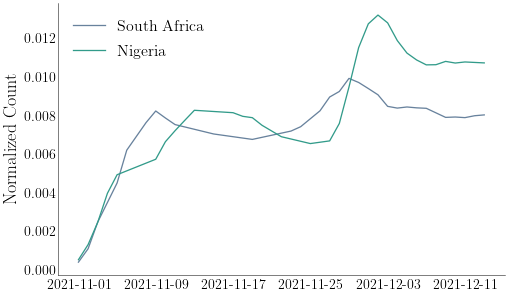

In [173]:
plt.figure(figsize=(8,5))
plt.plot(southafrica_vaccine_counts.index, southafrica_vaccine_counts.values, label='South Africa', linewidth=1.3)
plt.plot(nigeria_vaccine_counts.index, nigeria_vaccine_counts.values, label='Nigeria', linewidth=1.3)
plt.ylabel('Normalized Count', size=18)

plt.legend(fontsize=16, loc='upper left')

ax = plt.gca()

# Remove spines
sns.despine(top=True, right=True)
# Remove all of the extra tick marks
ax.minorticks_off()
ax.tick_params(top=False, right=False)
# Remove the ticks on the y axis
plt.tick_params(left = False, bottom=False)

# print(ax.get_xticklabels())

# Set every  four dates on the x axis
# ax.set_xticks(np.arange(0, len(omicron_dates), 7))
ax.set_xticks(omicron_dates[::8])

# Larger tick values
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

# plt.show()
plt.savefig('img/omicron_freq_plot_disag_country.pdf', bbox_inches='tight') 


## Omicron x vaccine hesitancy

In [184]:
#further restrict dataset
df_omicron_vac = df_omicron.loc[df_omicron['clean_transcription'].str.contains("vaccine|vaccines|vaccina|jabs|jab|antivax|antivax|no-vax|no-vax|immunisation|vaccination|vaccin|vaccins|anti-vaccin|refus vaccin|inocul", case=False)]
df_omicron_vac.shape

(763, 7)

In [185]:
df_omicron_vac = df_omicron_vac.loc[df_omicron_vac['clean_transcription'].str.contains("not effective|effectiveness", case=False)]
df_omicron_vac.shape

(18, 7)

In [186]:
df_omicron_vac

,date,city,text,clean_transcription,country,word_count,omicron
1728,2021-12-11,durban,of real rush games be now on luter star your w...,of real rush games be now on luter star your w...,South Africa,705,1
5135,2021-12-10,durban,andthank youhe wasnews on former fmit's 02:00 ...,andthank youhe wasnews on former fmits im on t...,South Africa,531,1
7199,2021-12-06,johannesburg,at least mobile you get the power of a free fi...,at least mobile you get the power of a free fi...,South Africa,802,1
8627,2021-11-30,johannesburg,his foundation wait's your early breakfast wit...,his foundation waits your early breakfast with...,South Africa,768,1
8921,2021-11-30,johannesburg,his foundation wait's your early breakfast wit...,his foundation waits your early breakfast with...,South Africa,768,1
8930,2021-11-30,johannesburg,of a sudden a double g almost double that so n...,of a sudden a double g almost double that so n...,South Africa,821,1
9058,2021-11-30,johannesburg,policy on masks right now you have a national ...,policy on masks right now you have a national ...,South Africa,903,2
9167,2021-11-30,johannesburg,policy on masks right now you have a national ...,policy on masks right now you have a national ...,South Africa,906,2
9632,2021-11-29,johannesburg,at bush garden's christmas town rekindle the s...,at bush gardens christmas town rekindle the sp...,South Africa,670,1
10729,2021-11-09,johannesburg,because the question is can you ever really fu...,because the question is can you ever really fu...,South Africa,769,2


In [176]:
df_omicron_vac['transcription'] = 1

In [177]:
df_omicron_vac_count = df_omicron_vac.groupby('date').sum().reset_index()
df_omicron_vac_count

,date,word_count,omicron,transcription
0,2021-11-09,769,2,1
1,2021-11-29,670,1,1
2,2021-11-30,4166,7,5
3,2021-12-01,664,1,1
4,2021-12-06,802,1,1
5,2021-12-08,3089,4,4
6,2021-12-09,789,3,1
7,2021-12-10,1776,8,3
8,2021-12-11,705,1,1


No handles with labels found to put in legend.


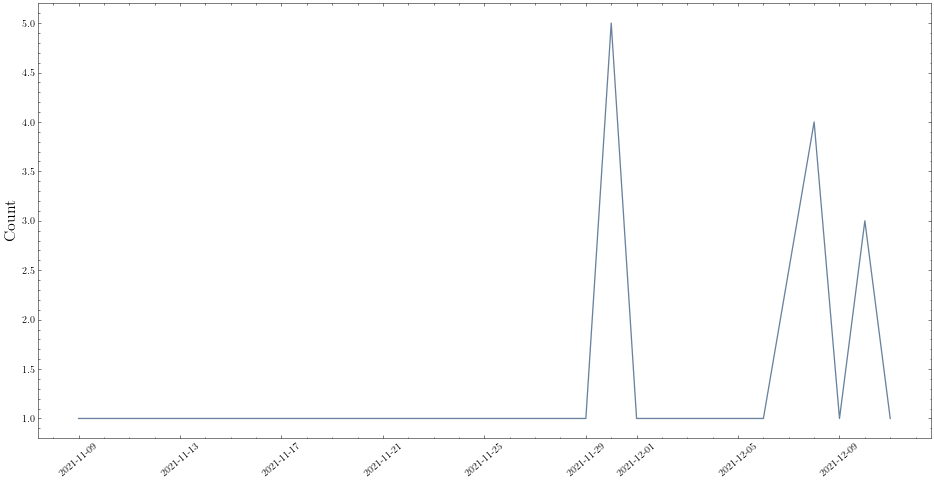

In [178]:
#plot - total number of transcriptions including a combination of relevant keywords per day
plt.figure(figsize = (16,8))
plt.plot(df_omicron_vac_count['date'], df_omicron_vac_count['transcription'], marker = '',
         linewidth = 1.3)
plt.ylabel('Count', size=16)
plt.xticks(rotation=40)
plt.legend()
plt.show()